In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import warnings

warnings.filterwarnings('ignore')

# Maltepe Sinir Koordinatlari

In [2]:
maltepe_sinir_koordinatlar = np.array([[40.95196465 , 29.09488678], [40.97277002 , 29.12621498], [40.97244599 , 29.14938927],
                                       [40.98054604 , 29.16217804], [40.97562133 , 29.18380737], [40.98106441 , 29.19788361], [40.97445490 , 29.19960022],
                                       [40.97562133 , 29.21230316], [40.97186275 , 29.21333313], [40.96058574 , 29.20715332], [40.94606537 , 29.21590805],
                                       [40.92401941 , 29.20543671], [40.92142529 , 29.19977188], [40.91390175 , 29.15737152], [40.91273423 , 29.15891647],
                                       [40.91013966 , 29.15119171], [40.91416119 , 29.14672852], [40.91065858 , 29.13883209], [40.90767472 , 29.13969040],
                                       [40.90689630 , 29.13814545], [40.91934991 , 29.12750244], [40.91909049 , 29.12321091], [40.93958203 , 29.10673141],
                                       [40.94269411 , 29.10741806], [40.95189983 , 29.09523010]])

maltepe_sinir_koordinatlar = pd.DataFrame(maltepe_sinir_koordinatlar)
maltepe_sinir_koordinatlar.columns = ['latitude', 'longitude']

max_longitude = maltepe_sinir_koordinatlar['longitude'].max()
min_longitude = maltepe_sinir_koordinatlar['longitude'].min()

max_latitude = maltepe_sinir_koordinatlar['latitude'].max()
min_latitude = maltepe_sinir_koordinatlar['latitude'].min()

# Maltepe Duraklar

In [2]:
duraklar = pd.read_csv('/home/umutky/Documents/bitirme_projesi/data/stops.csv')
duraklar.head()

,_id,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type
0,1,292235,100001,RIFAT ILGAZ CADDESÝ,direction: AVCILAR,41.0191700005564,28.684353,0.0
1,2,292236,100002,RIFAT ILGAZ CADDESÝ,direction: BOÐAZKÖY,41.0190470005563,28.684660,0.0
2,3,292237,100011,UZUNYAYLA,direction: AVCILAR,41.0104540005549,28.688629,0.0
3,4,292238,100012,UZUNYAYLA,direction: BOÐAZKÖY,41.010675000555,28.688751,0.0
4,5,292239,100021,OKTAY RIFAT CADDESÝ,direction: AVCILAR,41.0045240005537,28.695276,0.0


In [3]:
duraklar.dropna(inplace=True)

In [9]:
maltepe_duraklar = duraklar[duraklar['stop_desc'].str.contains('MALTEPE')].drop(['_id', 'stop_id', 'stop_code', 'stop_desc', 'location_type'], axis=1)
maltepe_duraklar.columns = ['stop_name', 'latitude', 'longitude']
maltepe_duraklar = maltepe_duraklar[(maltepe_duraklar['longitude'].astype(float) > min_lon) & (maltepe_duraklar['longitude'].astype(float) < max_lon) & (maltepe_duraklar['latitude'].astype(float) > min_lat) & (maltepe_duraklar['latitude'].astype(float) < max_lat)]
print(maltepe_duraklar.shape)
maltepe_duraklar.head()

(36, 3)


,stop_name,latitude,longitude
8512,BARBAROS HAYRETTÝNPAÞA ORTAOKULU,40.9501570054771,29.163828
9392,YEÞÝLTEPE SÝTESÝ,40.9489790005458,29.161268
9394,MALTEPE METRO ÝSTASYONU,40.9366150005438,29.139510
9528,MEDÝNE CAMÝÝ,40.9425150192166,29.149690
9530,ATATÜRK CADDESÝ,40.9413660005446,29.143386


In [10]:
import xml.etree.ElementTree as ET

# KML dosyasının yolu
kml_file = '/home/umutky/Documents/bitirme_projesi/data/minibus-duraklar-verisi.kml'

# Verileri depolamak için boş listeler oluşturun
names = []
coordinates = []

# KML dosyasını açın
tree = ET.parse(kml_file)
root = tree.getroot()

# KML dosyasındaki verileri işleyin
for placemark in root.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
    name = placemark.find('{http://www.opengis.net/kml/2.2}name').text
    coord = placemark.find('.//{http://www.opengis.net/kml/2.2}coordinates').text
    names.append(name)
    coordinates.append(coord)

# Verileri DataFrame'e dönüştürün
df = pd.DataFrame({'Name': names, 'Coordinates': coordinates})

# Koordinatları virgülle ayırarak yeni sütunlara bölün
df[['Latitude' , 'Longitude', 'Altitude']] = df['Coordinates'].str.split(',', expand=True)

# Gereksiz sütunları kaldırın
df.drop(['Altitude' ,'Coordinates'], axis=1, inplace=True)
df.columns = ['stop_name', 'longitude', 'latitude']
df['longitude'] = df['longitude']
df['latitude'] = df['latitude']
df.head()

maltepe_minibus_durak = df[(df['longitude'].astype(float) > min_lon) & (df['longitude'].astype(float) < max_lon) & (df['latitude'].astype(float) > min_lat) & (df['latitude'].astype(float) < max_lat)]
maltepe_minibus_durak = maltepe_minibus_durak.reindex(columns=['stop_name', 'latitude', 'longitude'])
print(maltepe_minibus_durak.shape)
maltepe_minibus_durak.head(1)

(35, 3)


,stop_name,latitude,longitude
394,kml_395,40.9748105400001,29.153867436


In [11]:
maltepe_duraklar = pd.concat([maltepe_duraklar, maltepe_minibus_durak]).reset_index(drop=True)
maltepe_duraklar['latitude'] = maltepe_duraklar['latitude'].astype(float)
maltepe_duraklar['longitude'] = maltepe_duraklar['longitude'].astype(float)
print(maltepe_duraklar.shape)
maltepe_duraklar.head(3)

(71, 3)


,stop_name,latitude,longitude
0,BARBAROS HAYRETTÝNPAÞA ORTAOKULU,40.950157,29.163828
1,YEÞÝLTEPE SÝTESÝ,40.948979,29.161268
2,MALTEPE METRO ÝSTASYONU,40.936615,29.139510


# Maltepe Akaryakit Istasyonlari

In [8]:
akaryakit_istasyonlari = pd.read_csv('C:/Users/umutk/Documents/derlenecek_Veriler/akaryakit_istasyonlari.csv')
akaryakit_istasyonlari.rename(columns={'longtitude': 'longitude'}, inplace=True)
akaryakit_istasyonlari.head()

,_id,adi,is_nevi,is_nevi_tnm,akaryakit_dagitim_sirketi,akaryakit_dagitim_sirketi_tnm,lpg_dagitim_sirketi,lpg_dagitim_sirketi_tnm,tesis_turu,tesis_turu_tnm,ilce_uavt,ilce,mahalle_uavt,mahalle_adi,latitude,longitude
0,1,GÜNEŞLİ PETROLCÜLÜK GIDA MADDELERİ VE TİCARET ...,2.0,Akaryakıt Lpg,22.0,KadOil,10.0,Aygaz,1,Aktif,2004,BAĞCILAR,40155.0,BAĞLAR,28.823000,41.031312
1,2,FULYA AKARYAKIT TİC. VE SAN. A.Ş.,1.0,Akaryakıt,10.0,Opet,NaN,Bilinmiyor,1,Aktif,1183,BEŞİKTAŞ,40221.0,DİKİLİTAŞ,28.999311,41.055087
2,3,ÇINAR AKARYAKIT OTOMOTİV İNŞAAT TARIM VE HAYVA...,2.0,Akaryakıt Lpg,12.0,Petrol Ofisi,47.0,Pogaz,1,Aktif,1835,PENDİK,40628.0,BAHÇELİEVLER,29.236304,40.886248
3,4,SÜRPA YAPI İNŞAAT OFSET MATBAACILIK HİZMETLERİ...,2.0,Akaryakıt Lpg,13.0,Shell-Turcas Petrol,39.0,Shell Gaz,1,Aktif,1782,BÜYÜKÇEKMECE,40929.0,KAMİLOBA,28.445831,41.035386
4,5,BİLGİN PETROL ÜRÜN.PAZ.İNŞ.SAN.VE TİC.A.Ş.,2.0,Akaryakıt Lpg,12.0,Petrol Ofisi,47.0,Pogaz,1,Aktif,2050,BAŞAKŞEHİR,40584.0,ŞAHİNTEPE,28.746095,41.063782


In [9]:
maltepe_akaryakit = akaryakit_istasyonlari[akaryakit_istasyonlari['ilce'] =='MALTEPE']
maltepe_akaryakit = maltepe_akaryakit[['longitude', 'latitude']]
maltepe_akaryakit.columns = ['latitude', 'longitude']
print(maltepe_akaryakit.shape)
maltepe_akaryakit.head()

(18, 2)


,latitude,longitude
20,40.923445,29.151015
40,40.929127,29.146179
66,40.927839,29.133069
68,40.947768,29.123439
77,40.937496,29.140928


# Trafik_Yogunluk

In [10]:
trafik = pd.read_csv('C:/Users/umutk/Documents/derlenecek_Veriler/trafik_yogunluk.csv')
trafik.columns = [col.lower() for col in trafik.columns.values]
trafik.head()

,_id,date_time,longitude,latitude,geohash,minimum_speed,maximum_speed,average_speed,number_of_vehicles
0,1,2024-02-01 00:00:00,29.273071,41.053162,sxkcd1,54,163,84,203
1,2,2024-02-01 00:00:00,28.591919,41.245422,sxk6ds,67,71,69,1
2,3,2024-02-01 00:00:00,28.767700,41.009216,sxk3q9,5,65,31,31
3,4,2024-02-01 00:00:00,28.778687,41.086121,sxk3wz,13,129,56,21
4,5,2024-02-01 00:00:00,28.701782,41.064148,sxk3t5,11,73,36,29


In [11]:
maltepe_trafik = trafik[(trafik['longitude'] > min_longitude) & (trafik['longitude'] < max_longitude) & (trafik['latitude'] > min_latitude) & ((trafik['latitude'] < max_latitude))]

maltepe_trafik = maltepe_trafik[['date_time', 'longitude', 'latitude', 'number_of_vehicles']]
maltepe_trafik = maltepe_trafik.reindex(columns=['date_time', 'latitude', 'longitude', 'number_of_vehicles'])
print(maltepe_trafik.shape)
maltepe_trafik.head()

(72628, 4)


,date_time,latitude,longitude,number_of_vehicles
9,2024-02-01 00:00:00,40.921326,29.174194,183
11,2024-02-01 00:00:00,40.954285,29.108276,27
57,2024-02-01 00:00:00,40.965271,29.196167,37
106,2024-02-01 00:00:00,40.943298,29.119263,27
238,2024-02-01 00:00:00,40.937805,29.108276,9


In [12]:
spesifik_trafik = maltepe_trafik[(maltepe_trafik['date_time']<='2024-02-05 21:00:00') & ((maltepe_trafik['date_time']>='2024-02-05 12:00:00'))]
spesifik_trafik.shape

(1096, 4)

# Ispark

In [12]:
import pandas as pd
import requests

# JSON verisini al
response = requests.get("https://api.ibb.gov.tr/ispark/Park")
otoparklar = response.json()

# JSON verisini DataFrame'e dönüştür
otoparklar = pd.DataFrame(otoparklar)

# DataFrame'i görüntüle
otoparklar.head()

,parkID,parkName,lat,lng,capacity,emptyCapacity,workHours,parkType,freeTime,district,isOpen
0,2381,1293 Yavuz Selim Otomatik Otoparkı,41.0233,28.9529,60,60,24 Saat,KAPALI OTOPARK,15,FATİH,1
1,2866,15 Temmuz Demokrasi Otogarı,41.0402,28.8942,1000,0,24 Saat,AÇIK OTOPARK,40,BAYRAMPAŞA,1
2,3068,15 Temmuz Şehitler Meydanı Zeminaltı Otoparkı,41.0251,29.0911,1029,252,24 Saat,KAPALI OTOPARK,15,ÜMRANİYE,1
3,2338,19 Mayıs Açık,41.0563,28.9941,65,0,24 Saat,AÇIK OTOPARK,0,ŞİŞLİ,1
4,787,19 Mayıs Caddesi 2,40.879,29.2305,15,5,09:00-18:00,YOL ÜSTÜ,15,PENDİK,1


In [13]:
maltepe_otopark = otoparklar[otoparklar['district'] == 'MALTEPE']
maltepe_otopark = maltepe_otopark[['parkName', 'lat', 'lng']]
maltepe_otopark.columns = ['parkName', 'latitude', 'longitude']
maltepe_otopark['latitude'] = maltepe_otopark['latitude'].astype(float)
maltepe_otopark['longitude'] = maltepe_otopark['longitude'].astype(float)
print(maltepe_otopark.shape)
maltepe_otopark.head()

(11, 3)


,parkName,latitude,longitude
311,Gülsuyu Metro Yer Altı Otoparkı,40.9237,29.1548
312,Gülsuyu Metro Yol Üstü 1,40.9235,29.1549
313,Gülsuyu Metro Yol Üstü 2,40.9234,29.1555
456,Maltepe Orhangazi Şehir Parkı Açık Otoparkı 1,40.9313,29.1161
457,Maltepe Rıhtım Caddesi 1,40.9238,29.1263


# ATM Banka

In [15]:
import pandas as pd

# Excel dosyasının yolu
excel_file = 'C:/Users/umutk/Documents/derlenecek_Veriler/poi.xlsx'

# İstenen sayfanın adı veya indeksi
sheet_name = 'ATM'  # veya 0, 1, 2, ...

# Excel dosyasındaki belirli sayfayı DataFrame olarak alın
maltepe_banka_atm = pd.read_excel(excel_file, sheet_name=sheet_name)
maltepe_banka_atm = maltepe_banka_atm[(maltepe_banka_atm['longitude'] > min_longitude) & (maltepe_banka_atm['longitude'] < max_longitude) & (maltepe_banka_atm['latitude'] > min_latitude) & ((maltepe_banka_atm['latitude'] < max_latitude))]
# DataFrame'i görüntüleme
print(maltepe_banka_atm.shape)
maltepe_banka_atm.head()

(266, 5)


,il,ilce,banka adi,latitude,longitude
1,İstanbul,Maltepe,Türkiye Garanti Bankasi A.S. Fatih Ünv.Hastanesi,40.910114,29.137978
2,İstanbul,Maltepe,Türkiye Cumhuriyeti Ziraat Bankasi A.S. Sarayl...,40.911130,29.168540
3,İstanbul,Maltepe,Akbank T.A.S. Cevizli Subesi 2,40.912030,29.154030
4,İstanbul,Maltepe,Türkiye Is Bankasi A.S. Maltepe Sahsuvaroglu Opet,40.916313,29.146736
5,İstanbul,Maltepe,QNB Finansbank A.S. 34 Cevizli Po,40.916378,29.146535


# Magazalar

In [14]:
# Coordinates of Migros stores.
migros_coordinates = [
    {"name": "KÜÇÜKYALI HILLTOWN MACROCENTER", "coordinate": [40.952686658232295, 29.121208035372987]},
    {"name": "PIAZZA MALTEPE MACROCENTER", "coordinate": [40.92128470164432, 29.165538126387283]},
    {"name": "ASKERİ LOJ. KÜÇÜKYALI İST M", "coordinate": [40.95468563836487, 29.123821421100054]},
    {"name": "IRMAKLAR SK MALTEPE İSTANBUL M", "coordinate": [40.94383179920128, 29.136009205869826]},
    {"name": "NISH ADALAR MALTEPE MM MİGROS", "coordinate": [40.94870794538319, 29.160562955773933]},
    {"name": "GİRNE MAH MALTEPE İST MİNİGROS", "coordinate": [40.938631772931316, 29.13806174161115]},
    {"name": "GÜLYOLU MALTEPE İST MİNİGROS", "coordinate": [40.92802770391542, 29.1389340834801]},
    {"name": "KADİR HAS CD. İST MİNİGROS", "coordinate": [40.9447965345502, 29.117321250036145]},
    {"name": "MENEKŞELİ SK. MALTEPE MİNİGROS", "coordinate": [40.925836713623404, 29.130363152522857]},
    {"name": "MALTEPE YALI CAD..MACROKIOSK", "coordinate": [40.918000068975864, 29.136015788077426]},
    {"name": "RİTİM AVM MALTEPE İSTANBUL MM", "coordinate": [40.92181694509281, 29.15815086660945]},
    {"name": "TUGAYYOLU MALTEPE MM MİGROS", "coordinate": [40.917428404776196, 29.159940216855254]},
    {"name": "OFİSPARK MALTEPE MM MİGROS", 'coordinate': [40.93799450691945, 29.135251567008822]},
    {"name": "MESA İSTANBUL MALTEPE MM", "coordinate": [40.93191548340477, 29.127265637593823]},
    {"name": "NARCITY MALTEPE İSTANBUL M", "coordinate": [40.95487209668625, 29.167318865563793]},
    {"name": "BAĞLARBAŞI MALTEPE M MİGROS", "coordinate": [40.92381052092096, 29.13449886571158]},
    {"name": "EVİNPARK MALTEPE M MİGROS", "coordinate": [40.936596283607656, 29.132266250105125]},
    {"name": "MJET MALTEPE YALI MAHALLESİ", "coordinate": [40.9185294335012, 29.133939204295885]},
    {"name": "MJET ZÜMRÜTEVLER MALTEPE İST", "coordinate": [40.93742235769825, 29.141501285893472]},
    {"name": "MJET FINDIKLI MALTEPE", "coordinate": [40.969187532857674, 29.12345584823173]},
    {"name": "MJET NİSH AVLU MALTEPE", "coordinate": [40.944371636564995, 29.15901126487112]},
    {"name": "MJET FİRUZ ÇIKMAZI MALTEPE İST", "coordinate": [40.94320780411222, 29.144398997022627]},
    {"name": "MJET ALTINTEPE İSTANBUL", "coordinate": [40.9527089740197, 29.097007129763984]},
    {"name": "MJET KÜÇÜKYALI 63", "coordinate": [40.94923165010923, 29.10590466959333]},
    {"name": "MJET KÜÇÜKYALI PO İSTASYON", "coordinate": [40.94791709562063, 29.10654747189149]},
    {"name": "MJET İDEALTEPE CADDE İSTANBUL", "coordinate": [40.938185139926404, 29.11945265477902]},
    {"name": "MJET ORHANGAZİ CADDESİ MALTEPE", "coordinate": [40.92147188412524, 29.148882922715064]},
    {"name": "MJET GİRNE MAHALLESİ MALTEPE", "coordinate": [40.94104461467149, 29.14056061182688]},
    {"name": "MJET MALTEPE NEVADA", "coordinate": [40.936220953009226, 29.125270928031444]},
    {"name": "MJET NİSH ADALAR", "coordinate": [40.9442638911282, 29.159328090876457]},
    {"name": "MJET FUAYE PO", "coordinate": [40.95051052069334, 29.162685408802766]},
    {"name": "ALTINTEPE M MİGROS", "coordinate": [40.95343875225428, 29.10032154626482]},
    {"name": "FUAYE İSTANBUL MMM MİGROS", "coordinate": [40.950149181140475, 29.165442147825367]},
    {"name": "KÜÇÜKYALI İSTANBUL M MİGROS", "coordinate": [40.944769195810856, 29.112264258198973]},
    {"name": "SÜREYYA PAŞA MMM MİGROS", "coordinate": [40.925774074670755, 29.124492347070344]}
]

# Coordinates of A101 stores.
a101_coordinates = [
    {"name": "Adalı", "coordinate": [40.927394883085235, 29.129755968898213]},
    {"name": "Adatepe", "coordinate": [40.945790719761604, 29.158524608036142]},
    {"name": "Ahmet Kutsi Tecer", "coordinate": [40.94697264869294, 29.108992595588575]},
    {"name": "Akarsu", "coordinate": [40.94320020106798, 29.14449386704606]},
    {"name": "Altayçeşme", "coordinate": [40.93709684710951, 29.129451295588076]},
    {"name": "Atatürk", "coordinate": [40.932473517602, 29.13659263658489]},
    {"name": "Ayerdem", "coordinate": [40.93334053257737, 29.126336916594965]},
    {"name": "Ayhan", "coordinate": [40.91748109292999, 29.150235387789607]},
    {"name": "Bağdat Park", "coordinate": [40.91869123203214, 29.142348945765892]},
    {"name": "Bağlarbaşı", "coordinate": [40.92390667555307, 29.135720080242788]},
    {"name": "Başıbüyük", "coordinate": [40.95806043821966, 29.147749778886645]},
    {"name": "Bülbül", "coordinate": [40.945248349238604, 29.121603422571827]},
    {"name": "Büyükbakkalköy", "coordinate": [40.97052190607659, 29.198820234230894]},
    {"name": "Camialtı", "coordinate": [40.958074773304325, 29.147542257606666]},
    {"name": "Canan", "coordinate": [40.93999089666084, 29.151950365579967]},
    {"name": "Değirmenyolu", "coordinate": [40.95442013315046, 29.101123215161365]},
    {"name": "Doğuşkent", "coordinate": [40.93947090004343, 29.139418992788137]},
    {"name": "Dragos", "coordinate": [40.91728899109436, 29.144277700000487]},
    {"name": "Efe Boz", "coordinate": [40.93624733683455, 29.133488717904036]},
    {"name": "Elifli", "coordinate": [40.93952567986965, 29.139381265431897]},
    {"name": "Ertuğrul Gazi", "coordinate": [40.948470330387245, 29.1547878715784]},
    {"name": "Eski Bağdat", "coordinate": [40.94702549200248, 29.109547693411244]},
    {"name": "Evren", "coordinate": [40.97198499803409, 29.130256420815687]},
    {"name": "Fatih", "coordinate": [40.92046478730853, 29.147404819387035]},
    {"name": "Figen", "coordinate": [40.92615799253096, 29.14552500589081]},
    {"name": "Filiz", "coordinate": [40.936578426258606, 29.14713455596701]},
    {"name": "Fındıklı", "coordinate": [40.971202286232355, 29.135924803001316]},
    {"name": "Girne", "coordinate": [40.943493943193914, 29.14495179745375]},
    {"name": "Grand House", "coordinate": [40.923046846303116, 29.131475958484746]},
    {"name": "Gül", "coordinate": [40.95218713357522, 29.10994516390435]},
    {"name": "Gülsuyu", "coordinate": [40.92764419655678, 29.15696404057653]},
    {"name": "Gülyolu", "coordinate": [40.92485574587402, 29.14088192613519]},
    {"name": "Güneşlik", "coordinate": [40.922768910478915, 29.168870251895438]},
    {"name": "Handegül", "coordinate": [40.94234542075043, 29.14945903212188]},
    {"name": "Hanımeli", "coordinate": [40.93781973383071, 29.145038866751978]},
    {"name": "Heykel", "coordinate": [40.931897227392454, 29.16420758354888]},
    {"name": "Kadir Has", "coordinate": [40.94368194803579, 29.117591299214254]},
    {"name": "Kartal", "coordinate": [40.93654913833068, 29.14726759744085]},
    {"name": "Kavaklıbayır", "coordinate": [40.96668135619129, 29.114802774304895]},
    {"name": "Kooperatif", "coordinate": [40.928863160423774, 29.14173620789344]},
    {"name": "Küçükyalı", "coordinate": [40.93234703451013, 29.136646549836268]},
    {"name": "Kılavuzçayırı", "coordinate": [40.95238151964869, 29.10986665140849]},
    {"name": "Kırlangıç", "coordinate": [40.92722413852877, 29.133725080243018]},
    {"name": "Kırçiçeği", "coordinate": [40.950434119475744, 29.127854717295303]},
    {"name": "Madenci", "coordinate": [40.94032453090845, 29.14242820164443]},
    {"name": "Maltepe", "coordinate": [40.92862045414734, 29.134665477144317]},
    {"name": "Mavıevler", "coordinate": [40.946097556545276, 29.12880362390243]},
    {"name": "Menekşeci Darkstore", "coordinate": [40.97140661473956, 29.133924370173283]},
    {"name": "Mercan", "coordinate": [40.97143901739909, 29.134138946895533]},
    {"name": "Namık Kemal", "coordinate": [40.93782327708093, 29.12133876675202]},
    {"name": "Nedim Özpolat", "coordinate": [40.91918156355658, 29.131472337914726]},
    {"name": "Nil Caddesı", "coordinate": [40.94123489075919, 29.153956025232937]},
    {"name": "Nish Adalar", "coordinate": [40.94683712314109, 29.16719959558862]},
    {"name": "Orhangazi", "coordinate": [40.920479325615176, 29.14735552723237]},
    {"name": "Orkide", "coordinate": [40.92358760959293, 29.14591311378964]},
    {"name": "Ortanca", "coordinate": [40.93233737572602, 29.164425964993736]},
    {"name": "Palmiye", "coordinate": [40.97043908018438, 29.130019595590085]},
    {"name": "Piri Reis", "coordinate": [40.91708383018474, 29.143594824422983]},
    {"name": "Preveze", "coordinate": [40.94865312002092, 29.12871766675268]},
    {"name": "Ritim İstanbul", "coordinate": [40.92122786710252, 29.157222156156422]},
    {"name": "Sahil", "coordinate": [40.919270134807334, 29.131550271622423]},
    {"name": "Saray Maltepe", "coordinate": [40.94276202024538, 29.114332385182973]},
    {"name": "Sarmaşık", "coordinate": [40.97197054979308, 29.130265509192995]},
    {"name": "Seyitağa", "coordinate": [40.96895696591541, 29.123756171008925]},
    {"name": "Seyrantepe", "coordinate": [40.94768409358067, 29.166132798526473]},
    {"name": "Sulhi Dönmezer", "coordinate": [40.930277200380615, 29.133284555638674]},
    {"name": "Sırmakeş", "coordinate": [40.9396458282932, 29.1528508161723]},
    {"name": "Talatpaşa", "coordinate": [40.9185783171644, 29.151399680297757]},
    {"name": "Toros", "coordinate": [40.91718960109349, 29.14424450598503]},
    {"name": "Tülin", "coordinate": [40.93491750586262, 29.148000761384083]},
    {"name": "Varna Maltepe", "coordinate": [40.93360061298113, 29.133128870889713]},
    {"name": "Yeni Hancıoğlu", "coordinate": [40.97002274280754, 29.140095813262924]},
    {"name": "Yeni Selvi", "coordinate": [40.96915224060489, 29.127712327367597]},
    {"name": "Yeni Selçukbey", "coordinate": [40.95041177110291, 29.127988561740242]},
    {"name": "Yeşiltepe", "coordinate": [40.93976307558044, 29.11683454795809]},
    {"name": "Yüzevler", "coordinate": [40.93410039239821, 29.12622891093225]},
    {"name": "Yıldırım", "coordinate": [40.92787699876612, 29.15715151412576]},
    {"name": "Zencefıl", "coordinate": [40.92719657520457, 29.16578829373469]},
    {"name": "Zuhal", "coordinate": [40.91765828300148, 29.154259993734073]},
    {"name": "Zümrüt Evler", "coordinate": [40.93969573233883, 29.117204716626933]},
    {"name": "Çamlı E5", "coordinate": [40.93965706296123, 29.133351893735465]},
    {"name": "Çağla", "coordinate": [40.947899653357794, 29.16649500612658]},
    {"name": "Çetin", "coordinate": [40.94873403528536, 29.108871445617062]},
    {"name": "Çınar Maltepe", "coordinate": [40.947581725490295, 29.109043179708422]},
    {"name": "Özmen", "coordinate": [40.947855637118835, 29.108184945533097]},
    {"name": "İdealtepe", "coordinate": [40.93946988115979, 29.117319572778445]}
]

# Coordinates of BIM stores.
bim_coordinates = [
    {"name": "5 ADA MALTEPE", "coordinate": [40.94386611375143, 29.1593275547878]},
    {"name": "50. YIL / MALTEPE", "coordinate": [40.94170836109047, 29.125923317801558]},
    {"name": "ADATEPE / MALTEPE", "coordinate": [40.934796487365354, 29.12198313146719]},
    {"name": "ALTINTEPE / MALTEPE", "coordinate": [40.95369322987723, 29.103950633501157]},
    {"name": "ATAMAN /MALTEPE", "coordinate": [40.96905938171349, 29.13207767054535]},
    {"name": "AYDINEVLER / MALTEPE", "coordinate": [40.94985677674711, 29.12786684694814]},
    {"name": "BAĞDAT /MALTEPE", "coordinate": [40.949654109509304, 29.10452194539834]},
    {"name": "BARIŞ / MALTEPE", "coordinate": [40.93989783562922, 29.154892719399843]},
    {"name": "BAŞAK / MALTEPE", "coordinate": [40.94800497158564, 29.11417993706625]},
    {"name": "BAŞARAN / MALTEPE", "coordinate": [40.93299949439397, 29.151859974628895]},
    {"name": "BAŞIBÜYÜK / MALTEPE", "coordinate": [40.95724604212229, 29.146871673430965]},
    {"name": "BAŞIBÜYÜK /MALTEPE", "coordinate": [40.97296800999857, 29.14446503813377]},
    {"name": "BEGONYA / MALTEPE", "coordinate": [40.93882155180379, 29.12830015179489]},
    {"name": "BEŞEVLER / MALTEPE", "coordinate": [40.92524624311455, 29.13240108769613]},
    {"name": "BÜYÜKTUR /MALTEPE", "coordinate": [40.93784048147304, 29.11952163506918]},
    {"name": "CADDE YÜZEVLER / MALTEPE", "coordinate": [40.930324252671795, 29.129116939058743]},
    {"name": "ÇAMLIK / MALTEPE", "coordinate": [40.94306827512642, 29.14447439353678]},
    {"name": "ÇARŞI / MALTEPE", "coordinate": [40.92526790248133, 29.13240319983509]},
    {"name": "ÇINAR / MALTEPE", "coordinate": [40.96856136703116, 29.140070293003298]},
    {"name": "DEĞİRMENYOLU /MALTEPE", "coordinate": [40.95450431329372, 29.101147948094518]},
    {"name": "DENİZCİLER / MALTEPE", "coordinate": [40.92680486970823, 29.144634970990133]},
    {"name": "DOĞUŞKENT / MALTEPE", "coordinate": [40.938922039048016, 29.140371114762267]},
    {"name": "DRAGOS / KARTAL", "coordinate": [40.91148500049741, 29.152348242954268]},
    {"name": "EFEBOZ /MALTEPE", "coordinate": [40.935995323794735, 29.13252067830462]},
    {"name": "EMEK /MALTEPE", "coordinate": [40.950260769456435, 29.11864830321464]},
    {"name": "ERCİYES / MALTEPE", "coordinate": [40.91571477764781, 29.14808064302144]},
    {"name": "ESENKENT / MALTEPE", "coordinate": [40.923207082700124, 29.16864021452266]},
    {"name": "EVREN CAD. / MALTEPE", "coordinate": [40.969633352419756, 29.123062987094592]},
    {"name": "FERAH / MALTEPE", "coordinate": [40.942204568009444, 29.153465990089504]},
    {"name": "FEYZULLAH / MALTEPE", "coordinate": [40.92376657950671, 29.129281481374232]},
    {"name": "GAZİ / MALTEPE", "coordinate": [40.97125053840908, 29.132820300844788]},
    {"name": "GİRNE / MALTEPE", "coordinate": [40.94339937502391, 29.13979040766674]},
    {"name": "GÜLENSU / MALTEPE", "coordinate": [40.933430436738576, 29.16353932315151]},
    {"name": "GÜLSUYU / MALTEPE", "coordinate": [40.92727775602385, 29.15667057051255]},
    {"name": "GÜLYOLU / MALTEPE", "coordinate": [40.92398979400527, 29.14078350068368]},
    {"name": "HANCIOĞLU / MALTEPE", "coordinate": [40.96908529499158, 29.13207796610294]},
    {"name": "HANIMELİ / MALTEPE", "coordinate": [40.93746760608058, 29.145266731005083]},
    {"name": "HASTANE / MALTEPE", "coordinate": [40.921854070921945, 29.13836770942411]},
    {"name": "IŞIKLAR / MALTEPE", "coordinate": [40.93265015812681, 29.136805254833604]},
    {"name": "İDEALTEPE / MALTEPE", "coordinate": [40.94253446386219, 29.114689753785473]},
    {"name": "İNCEYOL / MALTEPE", "coordinate": [40.954761889605436, 29.1117688779914]},
    {"name": "KADRİYE HATUN / MALTEPE", "coordinate": [40.94533439803117, 29.123663089916683]},
    {"name": "KANİPAŞA MALTEPE", "coordinate": [40.930472920695145, 29.16921541768973]},
    {"name": "KARACA / MALTEPE", "coordinate": [40.94791098129229, 29.15396458037732]},
    {"name": "KARADENİZ / MALTEPE", "coordinate": [40.94811934292254, 29.13046067218526]},
    {"name": "KARANFİL / MALTEPE", "coordinate": [40.94006352033881, 29.153250526834565]},
    {"name": "KARAYOLLARI / MALTEPE", "coordinate": [40.94634248278612, 29.118673632713776]},
    {"name": "KARDEŞ / MALTEPE", "coordinate": [40.92130331815685, 29.15163275563329]},
    {"name": "KENTPLUS /MALTEPE", "coordinate": [40.96776727420696, 29.125242132082306]},
    {"name": "KIRÇİÇEĞİ / MALTEPE", "coordinate": [40.950155909583316, 29.12333873804331]},
    {"name": "KIZILAY /MALTEPE", "coordinate": [40.93495294906234, 29.123986474315767]},
    {"name": "KOOPERATİF / MALTEPE", "coordinate": [40.92864245147052, 29.141128058917342]},
    {"name": "KÜÇÜKYALI / MALTEPE", "coordinate": [40.946811323681494, 29.109222604389288]},
    {"name": "MALTEPE / İSTANBUL", "coordinate": [40.927311770690615, 29.130783941688712]},
    {"name": "MENDERES/MALTEPE", "coordinate": [40.942094740070374, 29.146026787432554]},
    {"name": "MERCAN/MALTEPE", "coordinate": [40.935869299337135, 29.14681401412792]},
    {"name": "NADİRE / MALTEPE", "coordinate": [40.924720417049784, 29.16093599314204]},
    {"name": "OMEGA / MALTEPE", "coordinate": [40.944022249043236, 29.13390859205389]},
    {"name": "ORHANGAZİ / MALTEPE", "coordinate": [40.91929515747133, 29.14664457386512]},
    {"name": "ORTAK / MALTEPE", "coordinate": [40.932519065593176, 29.134445708448418]},
    {"name": "ÖZCAN / MALTEPE", "coordinate": [40.92008626106238, 29.139837187528876]},
    {"name": "SAĞLIK / MALTEPE", "coordinate": [40.93046024955185, 29.134863577367213]},
    {"name": "SAHİL / MALTEPE", "coordinate": [40.91805183551388, 29.13426704603057]},
    {"name": "SEVGİ / MALTEPE", "coordinate": [40.91765418027347, 29.14722682004058]},
    {"name": "SÜMBÜL / MALTEPE", "coordinate": [40.970288026441445, 29.124820764698743]},
    {"name": "SÜREYYA PAŞA / MALTEPE", "coordinate": [40.95437581782561, 29.14423945532768]},
    {"name": "TALATPAŞA / MALTEPE", "coordinate": [40.91796385005236, 29.150548171811565]},
    {"name": "TUGAYYOLU / MALTEPE", "coordinate": [40.918759046754715, 29.155692523034652]},
    {"name": "TURHAN / MALTEPE", "coordinate": [40.93667083938017, 29.1262822698654]},
    {"name": "TÜLİN / MALTEPE", "coordinate": [40.93600401826493, 29.148807687408983]},
    {"name": "YASEMİN / MALTEPE", "coordinate": [40.97221929574175, 29.143452562135174]},
    {"name": "YAVUZ SELİM / KARTAL", "coordinate": [40.91875168842416, 29.14293912954519]},
    {"name": "YENİ FINDIKLII /MALTEPE", "coordinate": [40.97166185657184, 29.13618596624144]},
    {"name": "YENİYOL MALTEPE", "coordinate": [40.92316922414561, 29.135729184801686]},
    {"name": "ZÜMRÜTEVLER / MALTEPE", "coordinate": [40.94241621779482, 29.14991393271687]}
]

# Coordinates of ŞOK stores.
sok_coordinates = [
    {"name": "İSTANBUL KÜÇÜKYALI KILAVUZ ÇAYIRI MAĞAZA", "coordinate": [40.952189, 29.108784]},
    {"name": "İSTANBUL ALTINTEPE MAĞAZASI", "coordinate": [40.954355, 29.103107]},
    {"name": "İSTANBUL MALTEPE KAMPÜS MAĞAZASI", "coordinate": [40.959541, 29.192393]},
    {"name": "İSTANBUL İÇERENKÖY FINDIKLI MAĞAZASI", "coordinate": [40.969200, 29.131538]},
    {"name": "İSTANBUL BAŞIBÜYÜK CADDE MAĞAZASI", "coordinate": [40.941176, 29.140728]},
    {"name": "İSTANBUL MALTEPE TALATPAŞA MAĞAZASI", "coordinate": [40.919074, 29.151436]},
    {"name": "İSTANBUL KARAYOLLARI 50.YIL PARKI MAĞAZASI", "coordinate": [40.943955, 29.119734]},
    {"name": "İSTANBUL TEYFİK SAĞLAM MALTEPE MAĞAZASI", "coordinate": [40.952918, 29.104535]},
    {"name": "İSTANBUL MEKTEP CD.MALTEPE MAĞAZASI", "coordinate": [40.950262, 29.111703]},
    {"name": "İSTANBUL ALTAY MALTEPE MAĞAZASI", "coordinate": [40.930548, 29.134566]},
    {"name": "İSTANBUL BAĞDATTEPE ALTINTEPE MAĞAZASI", "coordinate": [40.952598, 29.100870]},
    {"name": "İSTANBUL MALTEPE YALI MAĞAZASI", "coordinate": [40.926481, 29.152631]},
    {"name": "İSTANBUL ŞEHİT RIZA ESENKENT MAĞAZASI", "coordinate": [40.923483, 29.165234]},
    {"name": "İSTANBUL İNCEYOL SK.ALTINTEPE MAĞAZASI", "coordinate": [40.954505, 29.113231]},
    {"name": "İSTANBUL GALİPBEY CD.ALTINTEPE MAĞAZASI", "coordinate": [40.955847, 29.107113]},
    {"name": "İSTANBUL ESENKENT MAĞAZASI", "coordinate": [40.923551, 29.160437]},
    {"name": "İSTANBUL MALTEPE HANCIOĞLU", "coordinate": [40.968649, 29.129436]},
    {"name": "İSTANBUL ÇINAR MAH.KÜÇÜKYALI MAĞAZASI", "coordinate": [40.943042, 29.114093]},
    {"name": "İSTANBUL GİRNE MAHALLESİ ELİF SOKAK MAĞAZASI", "coordinate": [40.926883, 29.128331]},
    {"name": "İSTANBUL SÜMEN SK.İDEALTEPE MAĞAZASI", "coordinate": [40.952898, 29.096504]},
    {"name": "İSTANBUL MALTEPE KRİZANTEM MAĞAZASI", "coordinate": [40.924982, 29.128816]},
    {"name": "İSTANBUL KÜÇÜKYALI ALTMIŞÜÇ MAĞAZASI", "coordinate": [40.950446, 29.103232]},
    {"name": "İSTANBUL KÜÇÜKYALI ADİLE HANIM MAĞAZASI", "coordinate": [40.949261, 29.115270]},
    {"name": "İSTANBUL ZÜMRÜTEVLER ERTUĞRUL SOKAK MAĞAZASI", "coordinate": [40.934765, 29.148148]},
    {"name": "İSTANBUL MALTEPE İKİNCİ İLKOKUL CADDESİ MAĞAZASI", "coordinate": [40.922134, 29.132185]},
    {"name": "İSTANBUL ZÜMRÜTEVLER TÜLİN CADDE MAĞAZASI", "coordinate": [40.938321, 29.151346]},
    {"name": "İSTANBUL GÜLYOLU SK.MALTEPE MAĞAZASI", "coordinate": [40.925132, 29.140962]},
    {"name": "İSTANBUL FINDIKLI ÇINAR CADDESİ MAĞAZASI", "coordinate": [40.969513, 29.139731]},
    {"name": "İSTANBUL MALTEPE TEKEL BLOKLARI MAĞAZASI", "coordinate": [40.932258, 29.134530]},
    {"name": "İSTANBUL ZÜMRÜTEVLER KALEYURT MAĞAZASI", "coordinate": [40.947599, 29.153601]},
    {"name": "İSTANBUL MALTEPE YAVUZ SOKAK MAĞAZASI", "coordinate": [40.920362, 29.144546]},
    {"name": "İSTANBUL ZÜMRÜT EVLER FİLİZ SOKAK MAĞAZASI", "coordinate": [40.939159, 29.145238]},
    {"name": "MALTEPE TUGAY YOLU EMİR MAĞAZASI", "coordinate": [40.921834, 29.156493]},
    {"name": "İSTANBUL MALTEPE ÇIRAK SOKAK MAĞAZASI", "coordinate": [40.924587, 29.146540]},
    {"name": "MALTEPE EMEK CADDE MAĞAZASI", "coordinate": [40.935522, 29.153134]},
    {"name": "İSTANBUL MALTEPE ADALI SOKAK MAĞAZASI", "coordinate": [40.927510, 29.130667]},
    {"name": "ŞOK MİNİ-ZÜMRÜTEVLER MAĞAZASI", "coordinate": [40.935045, 29.150609]},
    {"name": "MALTEPE FINDIKLI PALMİYE CADDESİ MAĞAZASI", "coordinate": [40.971760, 29.130433]},
    {"name": "MALETEPE ŞEHİT HİKMET ALP CADDESİ MAĞAZASI", "coordinate": [40.935099, 29.123247]},
    {"name": "İSTANBUL KÜÇÜKYALI POYRAZ SOKAK MAĞAZASI", "coordinate": [40.947081, 29.130927]},
    {"name": "İSTANBUL MALTEPE BAŞIBÜYÜK YILDIZ SOK. MAĞAZASI", "coordinate": [40.960123, 29.147977]},
    {"name": "ZÜMRÜTEVLER AKŞEMSETTİN CAD MAĞAZASI", "coordinate": [40.936870, 29.146944]},
    {"name": "ŞOK MİNİ-YILMAZ2 MAĞAZASI", "coordinate": [40.934241, 29.169088]},
    {"name": "İSTANBUL MALTEPE KADİR HAS CAD MAĞAZASI", "coordinate": [40.942511, 29.115440]},
    {"name": "ŞOK MİNİ-ALTINTEPE MAĞAZASI", "coordinate": [40.957461, 29.107904]},
    {"name": "İSTANBUL MALTEPE BAĞLARBAŞI İNÖNÜ CAD MAĞAZASI", "coordinate": [40.926021, 29.139759]},
    {"name": "İSTANBUL ZÜMRÜTEVLER KARACA CAD MAĞAZASI", "coordinate": [40.942940, 29.150493]},
    {"name": "İSTANBUL ALTINTEPE CİHADİYE CAD MAĞAZASI", "coordinate": [40.957250, 29.109799]},
    {"name": "İSTANBUL FINDIKLI ATAMAN CAD MAĞAZASI", "coordinate": [40.970875, 29.136299]},
    {"name": "ŞOKMİNİ-GALİPBEY MAĞAZASI", "coordinate": [40.954035, 29.104301]},
    {"name": "ŞOKMİNİ-SERİN MAĞAZASI", "coordinate": [40.970562, 29.133730]},
    {"name": "İSTANBUL MALTEPE ZÜMRÜTEVLER GİRNE CADDESİ MAĞAZASI", "coordinate": [40.944261, 29.134404]},
    {"name": "ŞOKMİNİ-YEŞİM MAĞAZASI", "coordinate": [40.972993, 29.139488]},
    {"name": "İSTANBUL KÜÇÜKYALI MUHSİNE ZEYNEP MAĞAZASI", "coordinate": [40.949159, 29.109979]},
    {"name": "İSTANBUL İDEALTEPE SANİMALAZ MAĞAZASI", "coordinate": [40.939697, 29.123696]},
    {"name": "İSTANBUL KÜÇÜKYALI MAĞAZASI", "coordinate": [40.949145, 29.113653]},
    {"name": "SOK", "coordinate": [40.921895, 29.140198]},
    {"name": "SOK", "coordinate": [40.955561, 29.144312]},
    {"name": "SOK", "coordinate": [40.929097, 29.124747]},
    {"name": "SOK", "coordinate": [40.925507, 29.141474]},
    {"name": "SOK", "coordinate": [40.927605, 29.157823]},
    {"name": "SOK", "coordinate": [40.918120, 29.142264]},
    {"name": "SOK", "coordinate": [40.930739, 29.128214]},
    {"name": "SOK", "coordinate": [40.936377, 29.134379]},
    {"name": "SOK", "coordinate": [40.922829, 29.134557]},
    {"name": "SOK", "coordinate": [40.941625, 29.153924]},
    {"name": "SOK", "coordinate": [40.965537, 29.122726]},
    {"name": "SOK", "coordinate": [40.916711, 29.145928]},
    {"name": "SOK", "coordinate": [40.971277, 29.128718]},
    {"name": "SOK", "coordinate": [40.969552, 29.136297]},
    {"name": "SOK", "coordinate": [40.970841, 29.129463]},
    {"name": "SOK", "coordinate": [40.922590, 29.144178]},
    {"name": "SOK", "coordinate": [40.932640, 29.138548]},
    {"name": "SOK", "coordinate": [40.929145, 29.140261]},
    {"name": "SOK", "coordinate": [40.947687, 29.113293]},
    {"name": "SOK", "coordinate": [40.918976, 29.151566]},
    {'name': 'SOK', 'coordinate': [40.945944, 29.119339]},
    {'name': 'SOK', 'coordinate': [40.950443, 29.127770]},
    {'name': 'SOK', 'coordinate': [40.950820, 29.110796]},
    {'name': 'SOK', 'coordinate': [40.950602, 29.117542]},
    {'name': 'SOK', 'coordinate': [40.968465, 29.123094]}
]

In [15]:
# List to Pandas DataFrame.

names = [coord['name'] for coord in sok_coordinates]
coordinates = [coord['coordinate'] for coord in sok_coordinates]
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

sok_df = pd.DataFrame({'Name': names, 'Latitude': latitudes, 'Longitude': longitudes})

# BIM DATAFRAME
names = [coord['name'] for coord in bim_coordinates]
coordinates = [coord['coordinate'] for coord in bim_coordinates]
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

bim_df = pd.DataFrame({'Name': names, 'Latitude': latitudes, 'Longitude': longitudes})

# A101 DATAFRAME
names = [coord['name'] for coord in a101_coordinates]
coordinates = [coord['coordinate'] for coord in a101_coordinates]
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

a101_df = pd.DataFrame({'Name': names, 'Latitude': latitudes, 'Longitude': longitudes})

# MIGROS DATAFRAME
names = [coord['name'] for coord in migros_coordinates]
coordinates = [coord['coordinate'] for coord in migros_coordinates]
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

migros_df = pd.DataFrame({'Name': names, 'Latitude': latitudes, 'Longitude': longitudes})


# Rakip Magazalari Birlestir
tum_rakipler = pd.concat([bim_df, sok_df, a101_df])
tum_rakipler.columns = ['name', 'latitude', 'longitude']
tum_rakipler.head(2)

,name,latitude,longitude
0,5 ADA MALTEPE,40.943866,29.159328
1,50. YIL / MALTEPE,40.941708,29.125923


# Hesaplama ve Görselleştirme

GRIDLERIN BOYUTU

plt.xticks(np.arange(min_longitude, max_longitude, 0.002))
plt.yticks(np.arange(min_latitude, max_latitude, 0.003))

Maltepe ilcesi 50km2 yuz olcumune sahip bizim olusturdugumuz gridler 252m x 222m bu durumda bir gridin buyuklugu 0.05594400km2 etmektedir. Maltepe ilcesini yaklasik olarak 50/0.05594400 adet gride boldugumuzu gostermektedir.

In [16]:
# A coordinate we randomly chose in Maltepe
random_coordinate = (40.900, 29.090)

# The change in meters caused by a longitude step of 0.003 degrees at this point.
longitude_to_meters = geodesic(random_coordinate, (40.900, 29.093)).meters
print(f"The change in meters caused by a longitude step of 0.005 degrees at this point is approximately = {longitude_to_meters:.2f}m")

# The change in meters caused by a latitude step of 0.002 degrees at this point.
latitude_to_meters = geodesic(random_coordinate, (40.902, 29.090)).meters

print(f"The change in meters caused by a latitude step of 0.005 degrees at this point is approximately = {latitude_to_meters:.2f}m")

The change in meters caused by a longitude step of 0.005 degrees at this point is approximately = 252.79m
The change in meters caused by a latitude step of 0.005 degrees at this point is approximately = 222.10m


# SKLEARN kullanarak

trafik dahil edilmeden

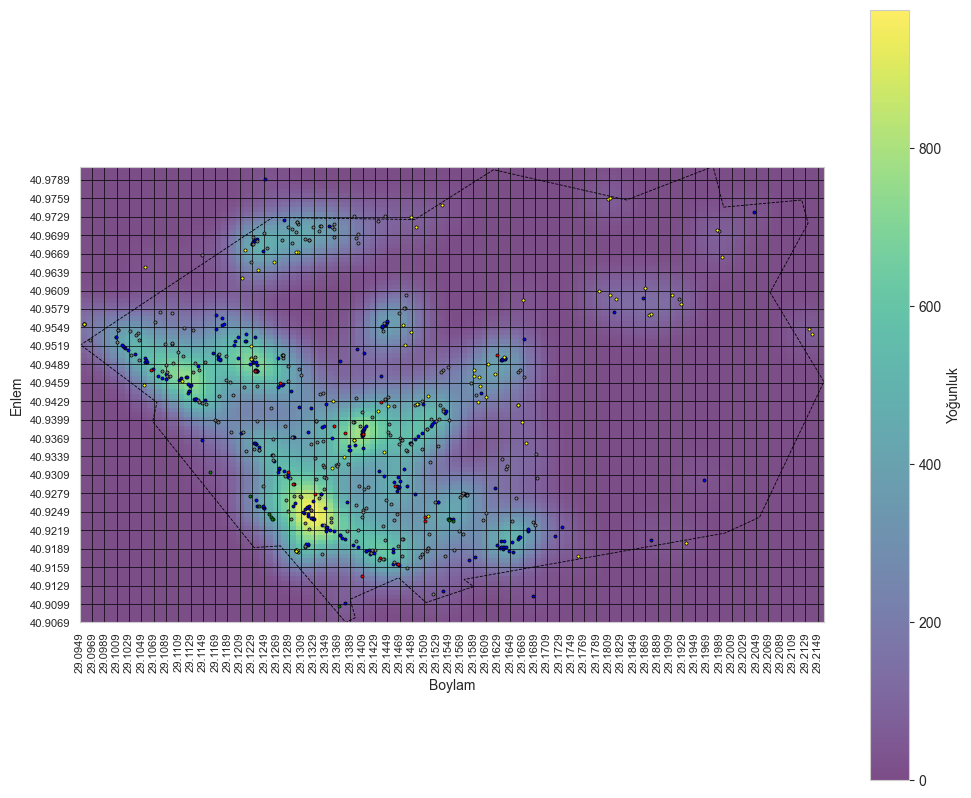

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values


# Tüm koordinatların birleştirilmesi
all_coords = np.concatenate([atm_coords, akarayakit_coords, tum_rakipler_coords, duraklar_coords, otopark_coords])

# Kernel Density Estimation (Çekirdek Yoğunluk Tahmini) modelinin oluşturulması
kde = KernelDensity(bandwidth=0.003, kernel='gaussian')  # Bandwidth ve kernel seçenekleri ayarlanabilir

# Modelin veriye uydurulması
kde.fit(all_coords)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_longitude:max_longitude:100j, min_latitude:max_latitude:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir ızgaradaki yoğunluk değerlerinin hesaplanması
density_all = np.exp(kde.score_samples(positions.T))
density_all = np.reshape(density_all, x_grid.shape)

# Figürün oluşturulması
plt.figure(figsize=(12, 10))

# Yoğunluk haritasının çizilmesi
plt.imshow(np.rot90(density_all), cmap=plt.cm.viridis, extent=[min_longitude, max_longitude, min_latitude, max_latitude], alpha=0.7)
plt.colorbar(label='Yoğunluk')

# Izgara çizgilerinin eklenmesi
plt.grid(color='black', linestyle='-', linewidth=0.5)

# ATM ve banka koordinatlarının scatter plot ile eklenmesi
plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)

# Başlık ve etiketlerin eklenmesi
plt.xticks(np.arange(min_longitude, max_longitude, 0.002), rotation=90, fontsize=8)
plt.yticks(np.arange(min_latitude, max_latitude, 0.003), fontsize=8)
plt.xlabel('Boylam')
plt.ylabel('Enlem')

# Maltepe ilçe sınırları
plt.plot(maltepe_sinir_koordinatlar.iloc[:, 1], maltepe_sinir_koordinatlar.iloc[:, 0], c='black', lw=0.6, linestyle='--', label='Maltepe İlçesi Sınırları')
plt.show()

Trafik dahil edildiginde.

Bu kisma duzenlemeler yapilmasi gerekmektedir.

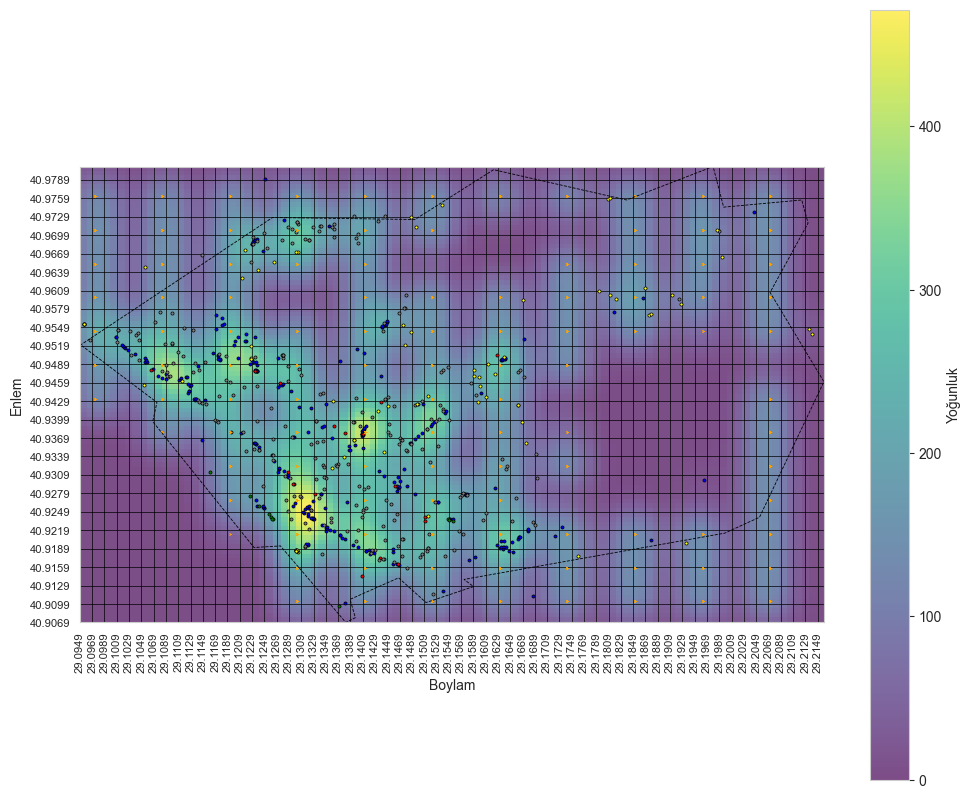

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
trafik_coords = spesifik_trafik[['longitude', 'latitude']].values

# Tüm koordinatların birleştirilmesi
all_coords = np.concatenate([atm_coords, akarayakit_coords, tum_rakipler_coords, duraklar_coords, otopark_coords, trafik_coords])

# Kernel Density Estimation (Çekirdek Yoğunluk Tahmini) modelinin oluşturulması
kde = KernelDensity(bandwidth=0.003, kernel='gaussian')  # Bandwidth ve kernel seçenekleri ayarlanabilir

# Modelin veriye uydurulması
kde.fit(all_coords)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_longitude:max_longitude:100j, min_latitude:max_latitude:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir ızgaradaki yoğunluk değerlerinin hesaplanması
density_all = np.exp(kde.score_samples(positions.T))
density_all = np.reshape(density_all, x_grid.shape)

# Figürün oluşturulması
plt.figure(figsize=(12, 10))

# Yoğunluk haritasının çizilmesi
plt.imshow(np.rot90(density_all), cmap=plt.cm.viridis, extent=[min_longitude, max_longitude, min_latitude, max_latitude], alpha=0.7)
plt.colorbar(label='Yoğunluk')

# Izgara çizgilerinin eklenmesi
plt.grid(color='black', linestyle='-', linewidth=0.5)

# ATM ve banka koordinatlarının scatter plot ile eklenmesi
plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(trafik_coords[:, 0], trafik_coords[:, 1], color='orange', label='trafik', marker='4', linewidth=.5, s=5)

# Başlık ve etiketlerin eklenmesi
plt.xticks(np.arange(min_longitude, max_longitude, 0.002), rotation=90, fontsize=8)
plt.yticks(np.arange(min_latitude, max_latitude, 0.003), fontsize=8)
plt.xlabel('Boylam')
plt.ylabel('Enlem')

# Maltepe ilçe sınırları
plt.plot(maltepe_sinir_koordinatlar.iloc[:, 1], maltepe_sinir_koordinatlar.iloc[:, 0], c='black', lw=0.6, linestyle='--', label='Maltepe İlçesi Sınırları')
plt.show()

# Yogunluklari scale ederek

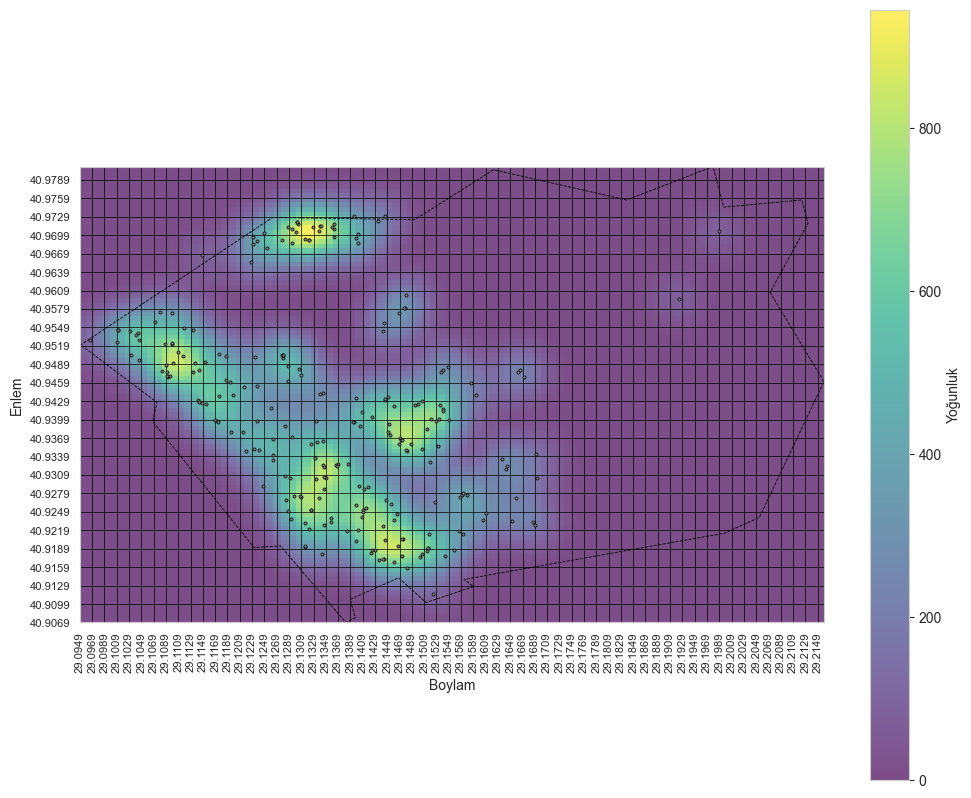

In [21]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
kendi_magazalarimiz = migros_df[['Longitude', 'Latitude']].values

# Tüm koordinatların birleştirilmesi
all_coords = tum_rakipler_coords

# Kernel Density Estimation (Çekirdek Yoğunluk Tahmini) modelinin oluşturulması
kde = KernelDensity(bandwidth=0.003, kernel='gaussian')  # Bandwidth ve kernel seçenekleri ayarlanabilir

# Modelin veriye uydurulması
kde.fit(all_coords)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_longitude:max_longitude:100j, min_latitude:max_latitude:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir ızgaradaki yoğunluk değerlerinin hesaplanması
density_all = np.exp(kde.score_samples(positions.T))
density_all = np.reshape(density_all, x_grid.shape)

#scaler = MinMaxScaler()
#density_all = scaler.fit_transform(density_all.reshape(-1, 1)).reshape(density_all.shape)
# Figürün oluşturulması
plt.figure(figsize=(12, 10))

# Yoğunluk haritasının çizilmesi
plt.imshow(np.rot90(density_all), cmap=plt.cm.viridis, extent=[min_longitude, max_longitude, min_latitude, max_latitude], alpha=0.7)
plt.colorbar(label='Yoğunluk')

# Izgara çizgilerinin eklenmesi
plt.grid(color='black', linestyle='-', linewidth=0.5)

# ATM ve banka koordinatlarının scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)

# Başlık ve etiketlerin eklenmesi
plt.xticks(np.arange(min_longitude, max_longitude, 0.002), rotation=90, fontsize=8)
plt.yticks(np.arange(min_latitude, max_latitude, 0.003), fontsize=8)
plt.xlabel('Boylam')
plt.ylabel('Enlem')

# Maltepe ilçe sınırları
plt.plot(maltepe_sinir_koordinatlar.iloc[:, 1], maltepe_sinir_koordinatlar.iloc[:, 0], c='black', lw=0.6, linestyle='--', label='Maltepe İlçesi Sınırları')
plt.show()

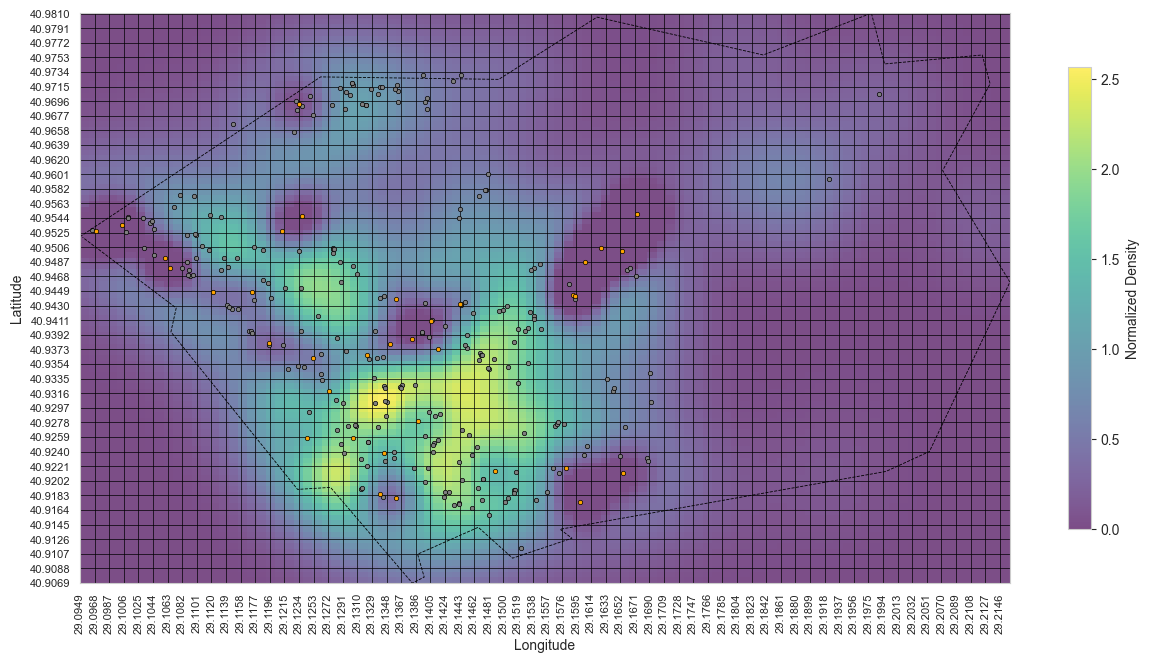

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
kde_atm = KernelDensity(bandwidth=0.006, kernel='gaussian').fit(atm_coords)
kde_akarayakit = KernelDensity(bandwidth=0.006, kernel='gaussian').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.006, kernel='gaussian').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.006, kernel='gaussian').fit(duraklar_coords)
kde_otopark = KernelDensity(bandwidth=0.006, kernel='gaussian').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.003, kernel='gaussian').fit(kendi_magazalarimiz)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_longitude:max_longitude:100j, min_latitude:max_latitude:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
density_atm = np.exp(kde_atm.score_samples(positions.T))
density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)

# Toplam yoğunluk hesaplama
total_density = scaled_density_atm + scaled_density_akarayakit + scaled_density_rakip_magaza + scaled_density_duraklar + scaled_density_otopark - 3*scaled_density_kendi_magaza
total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_longitude, max_longitude, min_latitude, max_latitude], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(min_longitude, max_longitude, 0.0019), rotation=90, fontsize=8)
plt.yticks(np.arange(min_latitude, max_latitude, 0.0019), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Koordintlarin scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)

plt.plot(maltepe_sinir_koordinatlar.iloc[:, 1], maltepe_sinir_koordinatlar.iloc[:, 0], c='black', lw=0.6, linestyle='--', label='Maltepe District Boundaries')
plt.show()

In [17]:
import json

# GeoJSON dosyasının yolu
dosya_yolu = "/home/umutky/Documents/bitirme_projesi/data/ilceler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
geojson_verisi["features"][11]

maltepe_ilce_polygon = geojson_verisi["features"][11]['geometry']

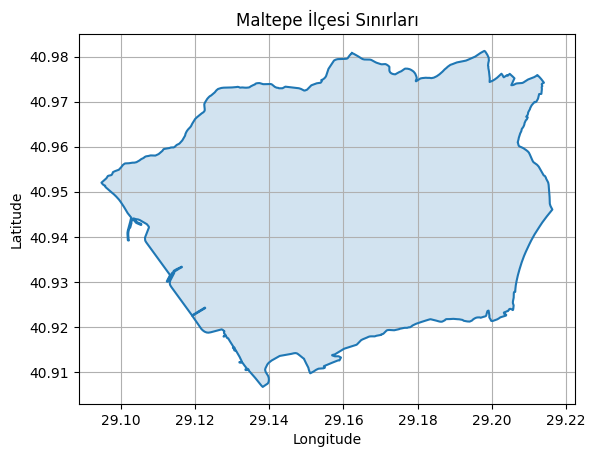

In [18]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y)
plt.fill(x, y, alpha=0.2)  # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [19]:
# En küçük ve en büyük koordinatları bulma
min_lon = min(coord[0] for coord in maltepe_ilce_polygon['coordinates'][0])
max_lon = max(coord[0] for coord in maltepe_ilce_polygon['coordinates'][0])
min_lat = min(coord[1] for coord in maltepe_ilce_polygon['coordinates'][0])
max_lat = max(coord[1] for coord in maltepe_ilce_polygon['coordinates'][0])

# Uç noktaları yazdırma
print("En küçük boylam (longitude):", min_lon)
print("En büyük boylam (longitude):", max_lon)
print("En küçük enlem (latitude):", min_lat)
print("En büyük enlem (latitude):", max_lat)

En küçük boylam (longitude): 29.0948141
En büyük boylam (longitude): 29.2163078
En küçük enlem (latitude): 40.906671
En büyük enlem (latitude): 40.9812459


In [21]:
import json

# GeoJSON dosyasının yolu
dosya_yolu = "/home/umutky/Documents/bitirme_projesi/data/mahalleler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
type(geojson_verisi)

dict

In [24]:
import json

# GeoJSON dosyasının yolu
dosya_yolu = "/home/umutky/Documents/bitirme_projesi/data/mahalleler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
type(geojson_verisi)



maltepe_mahalle = []
mahalle_adlari = ['Altayçeşme Mahallesi', 'Altıntepe Mahallesi', 'Aydınevler Mahallesi', 
                  'Bağlarbaşı Mahallesi', 'Başıbüyük Mahallesi', 'Büyükbakkalköy Mahallesi', 
                  'Cevizli Mahallesi', 'Çınar Mahallesi', 'Esenkent Mahallesi',
                  'Feyzullah Mahallesi', 'Fındıklı Mahallesi', 'Girne Mahallesi', 
                  'Gülensu Mahallesi', 'Gülsuyu Mahallesi', 'İdealtepe Mahallesi', 
                  'Küçükyalı Mahallesi', 'Yalı Mahallesi', 'Zümrütevler Mahallesi']

for feature in geojson_verisi['features']:
    properties = feature.get('properties', {})
    name = properties.get('name', None)
    if name in mahalle_adlari:
        maltepe_mahalle.append(feature)

# Maltepe ilçesi sınırlarının min ve max koordinatları arasındaki mahalleleri filtreleme
maltepe_mahalle_filtreli = []
for mahalle in maltepe_mahalle:
    coords = mahalle['geometry']['coordinates'][0]
    for lon, lat in coords:
        if min_lon <= lon <= max_lon and min_lat <= lat <= max_lat:
            maltepe_mahalle_filtreli.append(mahalle)
            break  # Sadece bir kere eklemek için

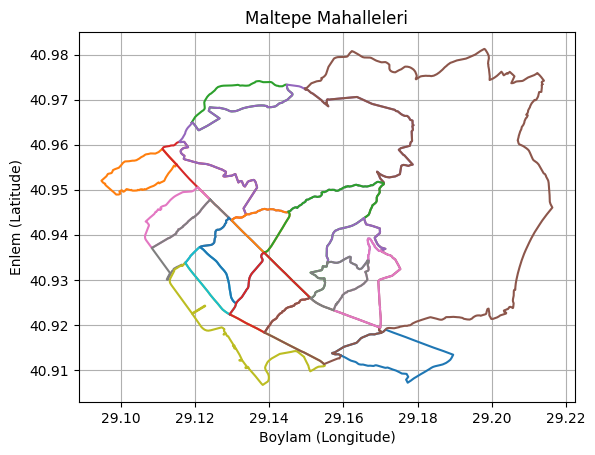

In [25]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'])

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)
plt.show()

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(duraklar_coords)
kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.001, kernel='gaussian', metric='haversine').fit(kendi_magazalarimiz)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:100j, min_lat:max_lat:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
density_atm = np.exp(kde_atm.score_samples(positions.T))
density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)

# Toplam yoğunluk hesaplama
total_density = scaled_density_atm + scaled_density_akarayakit + scaled_density_rakip_magaza + scaled_density_duraklar + scaled_density_otopark - 2*scaled_density_kendi_magaza
total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(min_lon, max_lon, 0.0019), rotation=90, fontsize=8)
plt.yticks(np.arange(min_lat, max_lat, 0.0019), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth= .5)

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)

# Koordintlarin scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)
plt.show()

NameError: name 'atm_coords' is not defined

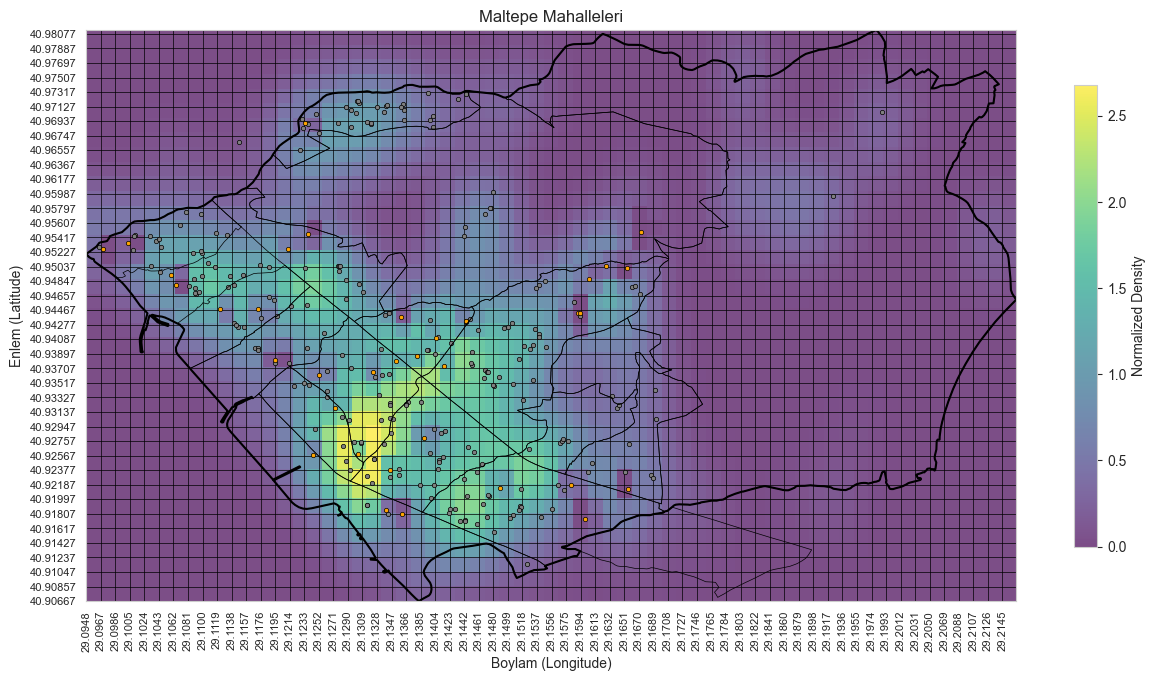

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(duraklar_coords)
kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.001, kernel='gaussian', metric='haversine').fit(kendi_magazalarimiz)

# İstediğiniz etiket aralıklarını belirleyin
lon_tick_interval = 0.0019
lat_tick_interval = 0.0019

# İzgara adım sayılarını hesaplayın
lon_num_steps = int((max_lon - min_lon) / lon_tick_interval)
lat_num_steps = int((max_lat - min_lat) / lat_tick_interval)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:lon_num_steps*1j, min_lat:max_lat:lat_num_steps*1j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
density_atm = np.exp(kde_atm.score_samples(positions.T))
density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)

# Toplam yoğunluk hesaplama
total_density = scaled_density_atm + scaled_density_akarayakit + scaled_density_rakip_magaza + scaled_density_duraklar + scaled_density_otopark - 2*scaled_density_kendi_magaza
total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(min_lon, max_lon, 0.0019), rotation=90, fontsize=8)
plt.yticks(np.arange(min_lat, max_lat, 0.0019), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth= .5)

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)

# Koordintlarin scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)
plt.show()

# OSM POI verilerini cekip ekleyelim, tekrardan olusturalim

In [27]:

import osmium
import csv

class POIHandler(osmium.SimpleHandler):
    def __init__(self, output_file):
        super(POIHandler, self).__init__()
        self.output_file = output_file

    def node(self, n):
        if 'amenity' in n.tags and n.tags['amenity'] in ['restaurant', 'cafe', 'bar', 'park', 'school']:
            # Maltepe ilçesindeki POI'leri filtrelemek için Maltepe'nin koordinatlarına göre kontrol yapabilirsiniz
            if n.location.lon >= min_lon and n.location.lon <= max_lon and n.location.lat >= min_lat and n.location.lat <= max_lat:
                # POI'nin konumu ve adını CSV dosyasına yaz
                with open(self.output_file, 'a', newline='', encoding='utf-8') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow([n.tags.get('name', 'Unknown'), n.location.lat, n.location.lon])

file_path = '/home/umutky/Documents/bitirme_projesi/data/turkey-latest.osm.pbf'
output_file = 'maltepe_poi.csv'

# CSV dosyasını temizle
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['POI Name', 'Latitude', 'Longitude'])

# POI işleyicisi oluştur
handler = POIHandler(output_file)

# OSM verilerini işle
handler.apply_file(file_path)

KeyboardInterrupt: 

In [33]:
atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
kendi_magazalarimiz = migros_df[['Longitude', 'Latitude']].values

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(duraklar_coords)
kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.001, kernel='gaussian', metric='haversine').fit(kendi_magazalarimiz)
kde_poi = KernelDensity(bandwidth=0.005, kernel='gaussian', metric='haversine').fit(poi_coords)

# İstediğiniz etiket aralıklarını belirleyin
lon_tick_interval = 0.0019
lat_tick_interval = 0.0019

# İzgara adım sayılarını hesaplayın
lon_num_steps = int((max_lon - min_lon) / lon_tick_interval)
lat_num_steps = int((max_lat - min_lat) / lat_tick_interval)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:lon_num_steps*1j, min_lat:max_lat:lat_num_steps*1j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
density_atm = np.exp(kde_atm.score_samples(positions.T))
density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))
density_poi = np.exp(kde_poi.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)
scaled_density_poi = scaler.fit_transform(density_poi.reshape(-1, 1)).reshape(density_poi.shape)

# Toplam yoğunluk hesaplama
total_density = scaled_density_atm + scaled_density_akarayakit + scaled_density_rakip_magaza + scaled_density_duraklar + scaled_density_otopark - 2*scaled_density_kendi_magaza + scaled_density_poi

total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.xticks(np.arange(min_lon, max_lon, 0.0019), rotation=90, fontsize=8)
#plt.yticks(np.arange(min_lat, max_lat, 0.0019), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth=0.3, linestyle='--')

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)

# Koordintlarin scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)
# plt.scatter(poi_coords[:, 0], poi_coords[:, 1], color='red', label='poi', marker='o', edgecolors='black', linewidth=.5, s=10)

plt.show()

NameError: name 'atm_coords' is not defined

# OSM POI'leri ile Son Hali

In [28]:
atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
kendi_magazalarimiz = migros_df[['Longitude', 'Latitude']].values

NameError: name 'maltepe_banka_atm' is not defined

In [21]:
# Ilce sinirlari
import json

# GeoJSON dosyasının yolu
dosya_yolu = "/home/umutky/PycharmProjects/engineering_project/data/ilceler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
geojson_verisi["features"][11]

maltepe_ilce_polygon = geojson_verisi["features"][11]['geometry']

In [20]:
# En küçük ve en büyük koordinatları bulma
min_lon = min(coord[0] for coord in maltepe_ilce_polygon['coordinates'][0])
max_lon = max(coord[0] for coord in maltepe_ilce_polygon['coordinates'][0])
min_lat = min(coord[1] for coord in maltepe_ilce_polygon['coordinates'][0])
max_lat = max(coord[1] for coord in maltepe_ilce_polygon['coordinates'][0])

# Uç noktaları yazdırma
print("En küçük boylam (longitude):", min_lon)
print("En büyük boylam (longitude):", max_lon)
print("En küçük enlem (latitude):", min_lat)
print("En büyük enlem (latitude):", max_lat)

En küçük boylam (longitude): 29.0948141
En büyük boylam (longitude): 29.2163078
En küçük enlem (latitude): 40.906671
En büyük enlem (latitude): 40.9812459


In [23]:
# Mahalle sinirlari
import json

# GeoJSON dosyasının yolu
dosya_yolu = "/home/umutky/PycharmProjects/engineering_project/data/mahalleler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
type(geojson_verisi)



maltepe_mahalle = []
mahalle_adlari = ['Altayçeşme Mahallesi', 'Altıntepe Mahallesi', 'Aydınevler Mahallesi', 
                  'Bağlarbaşı Mahallesi', 'Başıbüyük Mahallesi', 'Büyükbakkalköy Mahallesi', 
                  'Cevizli Mahallesi', 'Çınar Mahallesi', 'Esenkent Mahallesi',
                  'Feyzullah Mahallesi', 'Fındıklı Mahallesi', 'Girne Mahallesi', 
                  'Gülensu Mahallesi', 'Gülsuyu Mahallesi', 'İdealtepe Mahallesi', 
                  'Küçükyalı Mahallesi', 'Yalı Mahallesi', 'Zümrütevler Mahallesi']

for feature in geojson_verisi['features']:
    properties = feature.get('properties', {})
    name = properties.get('name', None)
    if name in mahalle_adlari:
        maltepe_mahalle.append(feature)

# Maltepe ilçesi sınırlarının min ve max koordinatları arasındaki mahalleleri filtreleme
maltepe_mahalle_filtreli = []
for mahalle in maltepe_mahalle:
    coords = mahalle['geometry']['coordinates'][0]
    for lon, lat in coords:
        if min_lon <= lon <= max_lon and min_lat <= lat <= max_lat:
            maltepe_mahalle_filtreli.append(mahalle)
            break  # Sadece bir kere eklemek için

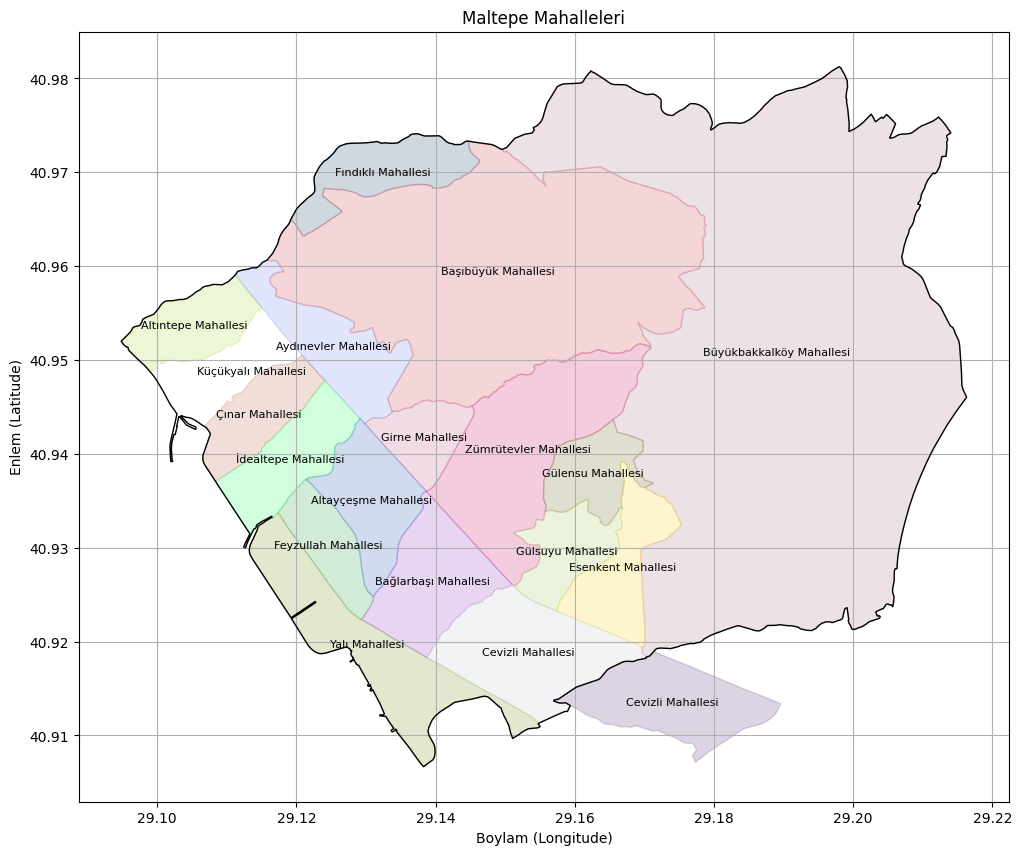

In [24]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.patches import Patch
import random

# Grafik nesnesini oluşturma
fig, ax = plt.subplots(figsize=(12,10))

maltepe_ilce_cek = Polygon(maltepe_ilce_polygon['coordinates'][0])
x, y = maltepe_ilce_cek.exterior.xy
ax.plot(x, y, color='black', linewidth=1)  # Kalınlığı 1 olan siyah bir çizgi

# Her bir mahalle için geometriyi dolgulu olarak gösterme
handles = []  # Legend için etiketleri ve renkleri saklamak için bir liste
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    
    # Rastgele bir renk seçme
    renk = (random.random(), random.random(), random.random())  # Rastgele RGB renk üretme
    ax.fill(x, y, color=renk, alpha=0.2)
    
    # Mahalle ismini etiket olarak ekleme
    centroid = polygon.centroid
    plt.text(centroid.x, centroid.y, mahalle_verisi['properties']['name'], fontsize=8, ha='center', va='center')
    
    # Legend için etiketleri ve renkleri saklama
    handles.append(Patch(color=renk, label=mahalle_verisi['properties']['name']))


# Küçükyalı Mahallesi'nin koordinatları
kucukyali_coordinate = [40.94875, 29.11350]
kucukyali_name = 'Küçükyalı Mahallesi'

plt.text(kucukyali_coordinate[1], kucukyali_coordinate[0], kucukyali_name, fontsize=8, ha='center', va='center')

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)

plt.show()

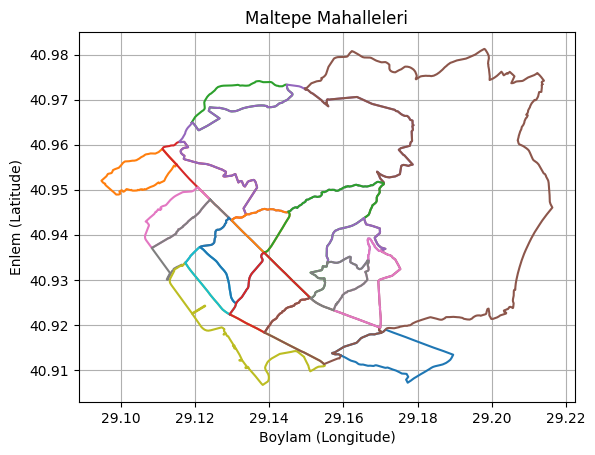

In [25]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'])

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)
plt.show()

In [29]:
import geopandas as gpd

# GeoJSON dosyasını açma
file_path = "/home/umutky/PycharmProjects/engineering_project/data/hotosm_tur_points_of_interest_points_geojson.geojson"
gdf = gpd.read_file(file_path)

# Geometry sütunundaki koordinatları ayırma
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y

# Geometry sütununu kaldırma
gdf = gdf.drop(columns=['geometry'])

gdf = gdf[(gdf['longitude'] > min_lon) & (gdf['longitude'] < max_lon) & (gdf['latitude'] > min_lat) & ((gdf['latitude'] < max_lat))]

gdf.to_csv('maltepe_poi.csv', index=False)
# DataFrame'i inceleme
print(gdf.shape)

(2930, 19)


In [30]:
#atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
#akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
#poi_coords = osm_poi[['Longitude', 'Latitude']].values
#otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
kendi_magazalarimiz = migros_df[['Longitude', 'Latitude']].values
yeni_poi_coords = gdf[['longitude', 'latitude']].values

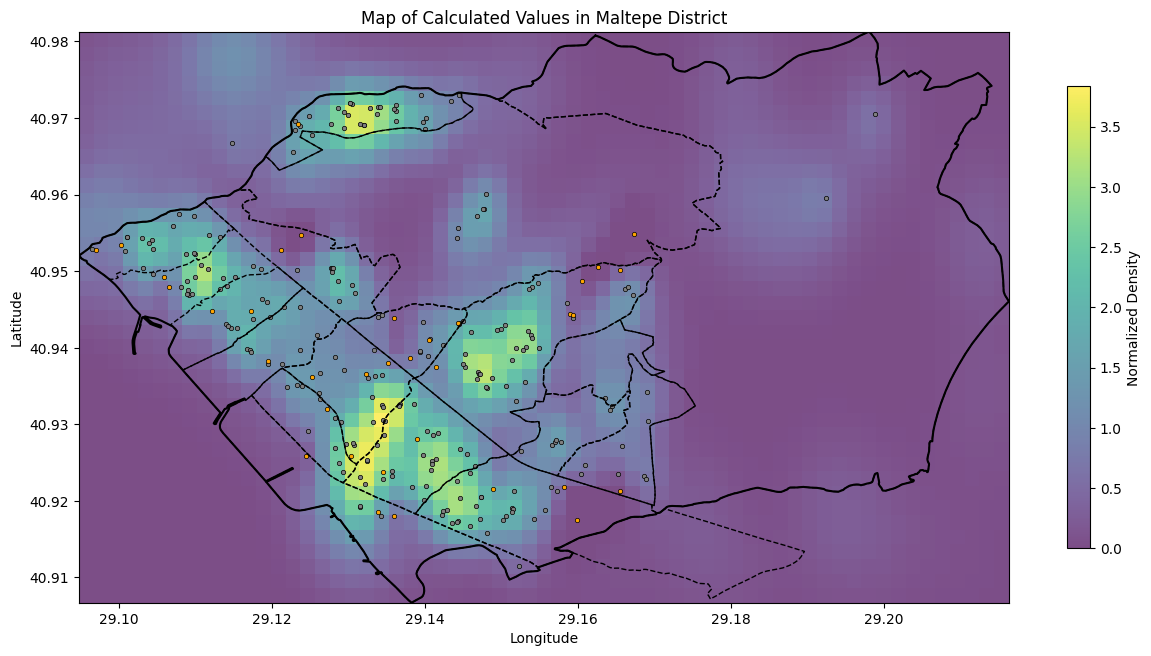

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
#kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
#kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.002, kernel='gaussian', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.004, kernel='gaussian', metric='haversine').fit(duraklar_coords)
#kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.002, kernel='gaussian', metric='haversine').fit(kendi_magazalarimiz)
#kde_poi = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(poi_coords)
kde_yeni_poi = KernelDensity(bandwidth=0.004, kernel='gaussian', metric='haversine').fit(yeni_poi_coords)

# İstediğiniz etiket aralıklarını belirleyin
lon_tick_interval = 0.0019
lat_tick_interval = 0.0019

# İzgara adım sayılarını hesaplayın
lon_num_steps = int((max_lon - min_lon) / lon_tick_interval)
lat_num_steps = int((max_lat - min_lat) / lat_tick_interval)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:lon_num_steps*1j, min_lat:max_lat:lat_num_steps*1j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
#density_atm = np.exp(kde_atm.score_samples(positions.T))
#density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
#density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))
#density_poi = np.exp(kde_poi.score_samples(positions.T))
density_yeni_poi = np.exp(kde_yeni_poi.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
#scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
#scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
#scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)
#scaled_density_poi = scaler.fit_transform(density_poi.reshape(-1, 1)).reshape(density_poi.shape)
scaled_density_yeni_poi = scaler.fit_transform(density_yeni_poi.reshape(-1, 1)).reshape(density_yeni_poi.shape)

# Toplam yoğunluk hesaplama
total_density = 3*scaled_density_rakip_magaza + 1.2*scaled_density_duraklar - 1.4*scaled_density_kendi_magaza + 1.2*scaled_density_yeni_poi
total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.xticks(np.arange(min_lon, max_lon, lon_tick_interval), rotation=90, fontsize=8)
#plt.yticks(np.arange(min_lat, max_lat, lat_tick_interval), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth=1, linestyle='--')

# Grafiği gösterme
plt.title('Map of Calculated Values in Maltepe District')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False) # Gridlerin gozukmesi icin acmalisin.

# Koordintlarin scatter plot ile eklenmesi
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)

plt.show()

## Threshold degerine gore koordinat secme

In [32]:
# A coordinate we randomly chose in Maltepe
random_coordinate = (40.900, 29.090)

# The change in meters caused by a longitude step of 0.003 degrees at this point.
longitude_to_meters = geodesic(random_coordinate, (40.900, 29.0919)).meters
print(f"The change in meters caused by a longitude step of 0.0019 degrees at this point is approximately = {longitude_to_meters:.2f}m")

# The change in meters caused by a latitude step of 0.002 degrees at this point.
latitude_to_meters = geodesic(random_coordinate, (40.9019, 29.090)).meters

print(f"The change in meters caused by a latitude step of 0.0019 degrees at this point is approximately = {latitude_to_meters:.2f}m")

The change in meters caused by a longitude step of 0.0019 degrees at this point is approximately = 160.10m
The change in meters caused by a latitude step of 0.0019 degrees at this point is approximately = 211.00m


longitude = 64 and latitude 40
The change in meters caused by a longitude step of 0.005 degrees at this point is approximately = 160.10m
The change in meters caused by a latitude step of 0.005 degrees at this point is approximately = 211.00m
total grid = 2560

In [33]:
# Eşik değeri belirleme
threshold = 3.25

# Koordinatlar ve yoğunluk değerlerini saklamak için bir sözlük oluşturma
selected_coordinates_with_density = {}

# total_density değerlerini ve koordinatları dolaşma
for i in range(total_density.shape[0]):
    for j in range(total_density.shape[1]):
        if total_density[i, j] > threshold:
            selected_coordinates_with_density[(x_grid[i, j], y_grid[i, j])] = total_density[i, j]

df = pd.DataFrame(list(selected_coordinates_with_density.items()), columns=['Coordinate', 'Density'])

# Koordinatları ayırmak için bir fonksiyon
def split_coordinate(coord):
    return coord[0], coord[1]

# 'Coordinate' sütunundaki verileri ayrıştırma
df['longitude'], df['latitude'] = zip(*df['Coordinate'].apply(split_coordinate))
df.drop('Coordinate', axis=1, inplace=True)
print(df.shape)

(18, 3)


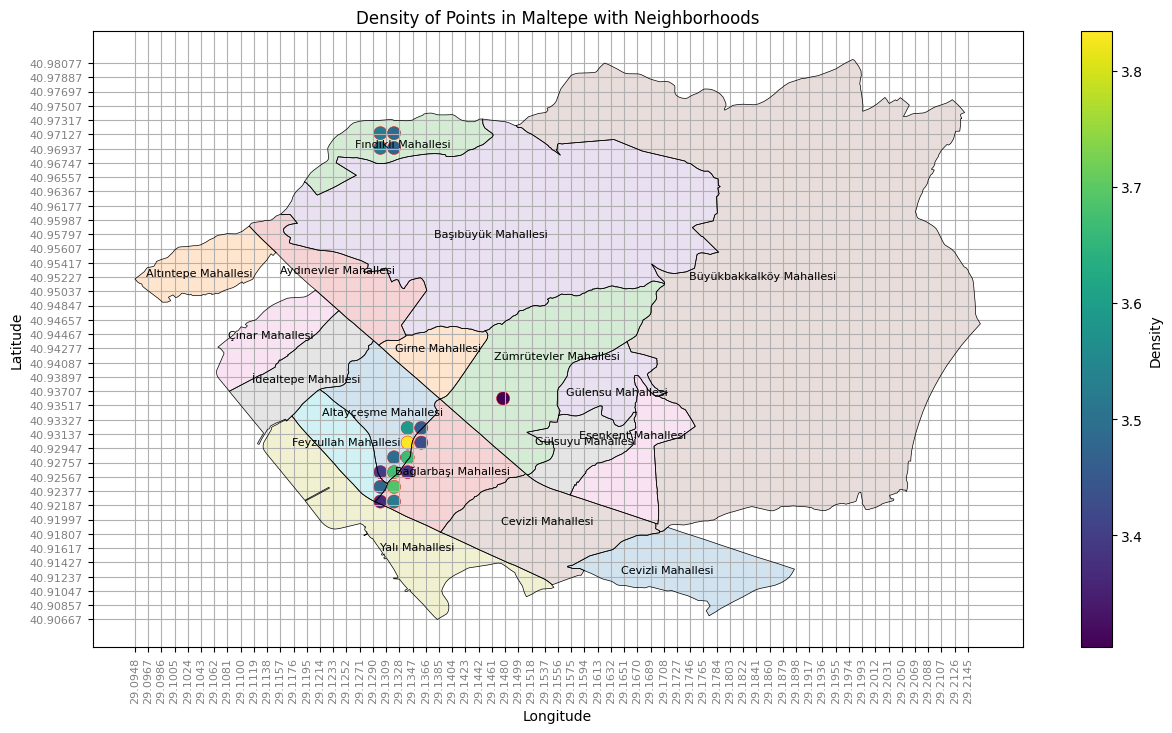

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Haritayı çizin ve büyütün
plt.figure(figsize=(15, 8))

# Mahalleleri farklı renklerde çizin
for feature in maltepe_mahalle_filtreli:
    coordinates = feature['geometry']['coordinates'][0]
    x, y = zip(*coordinates)
    plt.fill(x, y, alpha=0.2)  # Mahallelerin içini boyayalım
    plt.plot(x, y, linewidth=0.5, color='black')

    # Mahalle isimlerini içine yazdırma
    centroid_x = sum(x) / len(x)
    centroid_y = sum(y) / len(y)
    plt.text(centroid_x, centroid_y, feature['properties']['name'], fontsize=8, verticalalignment='center', horizontalalignment='center')

# Noktaları ve yoğunluk değerlerini görselleştirme
sc = plt.scatter(df['longitude'], df['latitude'], c=df['Density'], cmap='viridis', s=90, alpha=1, edgecolors='r', linewidths=0.3, norm=Normalize(vmin=min(df['Density']), vmax=max(df['Density'])))
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Eksen etiketlerini ve başlığı ayarla
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density of Points in Maltepe with Neighborhoods')

plt.xticks(np.arange(min_lon, max_lon, lon_tick_interval), rotation=90, fontsize=8, color='grey')
plt.yticks(np.arange(min_lat, max_lat, lat_tick_interval), fontsize=8, color='grey')

# Haritayı göster
plt.grid(True)
plt.show()

# epanechnikov kernel kullanılarak yapılan çalışma

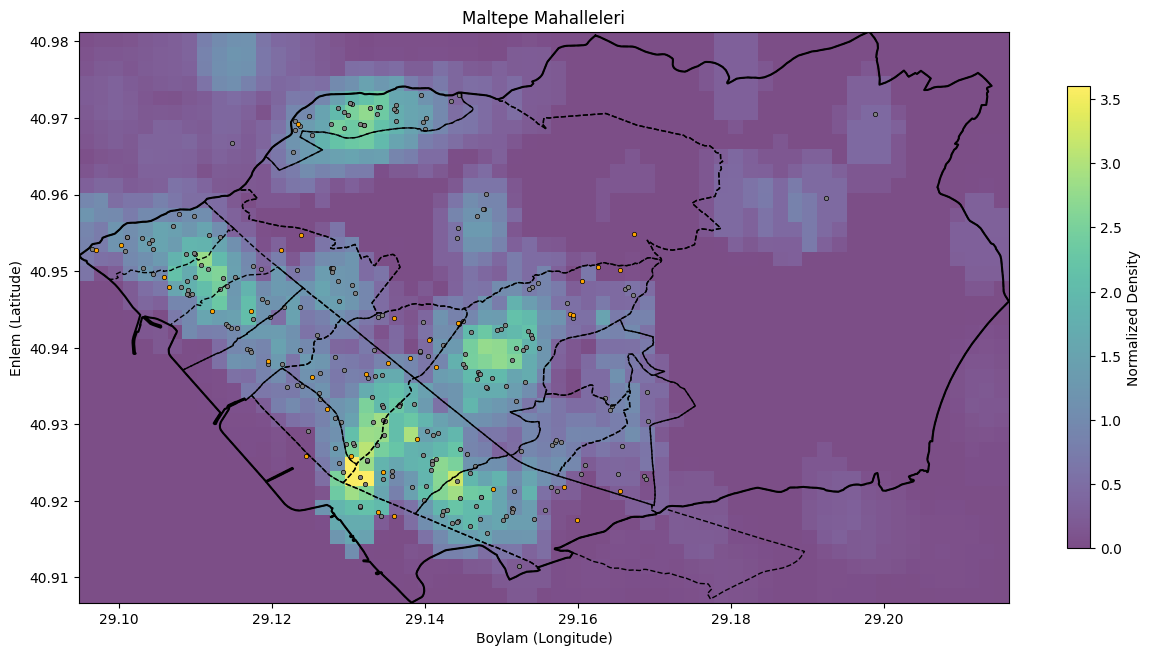

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
#kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
#kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.004, kernel='tophat', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.004, kernel='tophat', metric='haversine').fit(duraklar_coords)
#kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.004, kernel='tophat', metric='haversine').fit(kendi_magazalarimiz)
#kde_poi = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(poi_coords)
kde_yeni_poi = KernelDensity(bandwidth=0.004, kernel='tophat', metric='haversine').fit(yeni_poi_coords)

# İstediğiniz etiket aralıklarını belirleyin
lon_tick_interval = 0.0019
lat_tick_interval = 0.0019

# İzgara adım sayılarını hesaplayın
lon_num_steps = int((max_lon - min_lon) / lon_tick_interval)
lat_num_steps = int((max_lat - min_lat) / lat_tick_interval)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:lon_num_steps*1j, min_lat:max_lat:lat_num_steps*1j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
#density_atm = np.exp(kde_atm.score_samples(positions.T))
#density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
#density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))
#density_poi = np.exp(kde_poi.score_samples(positions.T))
density_yeni_poi = np.exp(kde_yeni_poi.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
#scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
#scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
#scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)
#scaled_density_poi = scaler.fit_transform(density_poi.reshape(-1, 1)).reshape(density_poi.shape)
scaled_density_yeni_poi = scaler.fit_transform(density_yeni_poi.reshape(-1, 1)).reshape(density_yeni_poi.shape)

# Toplam yoğunluk hesaplama
total_density = 3*scaled_density_rakip_magaza + 1.2*scaled_density_duraklar - 1.4*scaled_density_kendi_magaza + 1.2*scaled_density_yeni_poi

total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.xticks(np.arange(min_lon, max_lon, lon_tick_interval), rotation=90, fontsize=8)
#plt.yticks(np.arange(min_lat, max_lat, lat_tick_interval), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth=1, linestyle='--')

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(False) # Gridlerin gozukmesi icin acmalisin.

# Koordintlarin scatter plot ile eklenmesi
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(yeni_poi_coords[:, 0], yeni_poi_coords[:, 1], color='red', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10, alpha=0.3)

plt.show()

In [47]:
total_density.max()

3.599920424403173

In [48]:
# Eşik değeri belirleme
threshold = 3

# Koordinatlar ve yoğunluk değerlerini saklamak için bir sözlük oluşturma
selected_coordinates_with_density = {}

# total_density değerlerini ve koordinatları dolaşma
for i in range(total_density.shape[0]):
    for j in range(total_density.shape[1]):
        if total_density[i, j] > threshold:
            selected_coordinates_with_density[(x_grid[i, j], y_grid[i, j])] = total_density[i, j]

df = pd.DataFrame(list(selected_coordinates_with_density.items()), columns=['Coordinate', 'Density'])

# Koordinatları ayırmak için bir fonksiyon
def split_coordinate(coord):
    return coord[0], coord[1]

# 'Coordinate' sütunundaki verileri ayrıştırma
df['longitude'], df['latitude'] = zip(*df['Coordinate'].apply(split_coordinate))
df.drop('Coordinate', axis=1, inplace=True)
print(df.shape)

(5, 3)


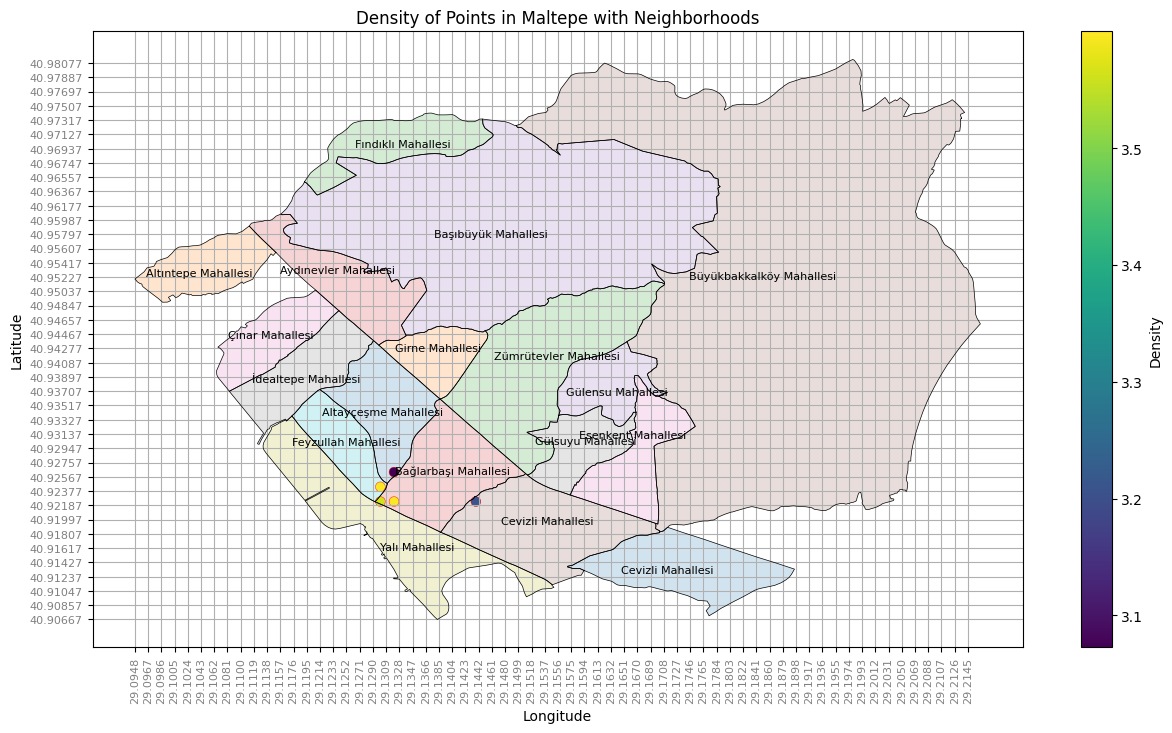

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Haritayı çizin ve büyütün
plt.figure(figsize=(15, 8))

# Mahalleleri farklı renklerde çizin
for feature in maltepe_mahalle_filtreli:
    coordinates = feature['geometry']['coordinates'][0]
    x, y = zip(*coordinates)
    plt.fill(x, y, alpha=0.2)  # Mahallelerin içini boyayalım
    plt.plot(x, y, linewidth=0.5, color='black')

    # Mahalle isimlerini içine yazdırma
    centroid_x = sum(x) / len(x)
    centroid_y = sum(y) / len(y)
    plt.text(centroid_x, centroid_y, feature['properties']['name'], fontsize=8, verticalalignment='center', horizontalalignment='center')

# Noktaları ve yoğunluk değerlerini görselleştirme
sc = plt.scatter(df['longitude'], df['latitude'], c=df['Density'], cmap='viridis', s=50, alpha=1, edgecolors='r', linewidths=0.3, norm=Normalize(vmin=min(df['Density']), vmax=max(df['Density'])))
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Eksen etiketlerini ve başlığı ayarla
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density of Points in Maltepe with Neighborhoods')

plt.xticks(np.arange(min_lon, max_lon, lon_tick_interval), rotation=90, fontsize=8, color='grey')
plt.yticks(np.arange(min_lat, max_lat, lat_tick_interval), fontsize=8, color='grey')

# Haritayı göster
plt.grid(True)
plt.show()

# Önlem amaçlı şimdi silme

In [125]:
import json

# GeoJSON dosyasının yolu
dosya_yolu = "C:/Users/umutk/Downloads/ilceler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
geojson_verisi["features"][11]

maltepe_ilce_polygon = geojson_verisi["features"][11]['geometry']

{'type': 'Feature',
 'properties': {'@id': 'relation/1276407',
  'admin_level': '6',
  'boundary': 'administrative',
  'name': 'Maltepe',
  'name:ru': 'Малтепе',
  'network': 'TR34-districts',
  'type': 'boundary',
  'wikidata': 'Q739547',
  'wikipedia': 'tr:Maltepe'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[29.1623025, 40.9807639],
    [29.1620748, 40.9805926],
    [29.1617301, 40.9802889],
    [29.1614538, 40.9800034],
    [29.1613224, 40.9798373],
    [29.1612178, 40.9796936],
    [29.1610998, 40.9795984],
    [29.1609791, 40.9795498],
    [29.1608218, 40.9795204],
    [29.160727, 40.9795052],
    [29.1600564, 40.9794688],
    [29.1590828, 40.9794445],
    [29.158541, 40.9794253],
    [29.1583358, 40.9793979],
    [29.1579147, 40.9792967],
    [29.1577309, 40.9792268],
    [29.1575539, 40.9791509],
    [29.157476, 40.9791139],
    [29.1569276, 40.9784462],
    [29.1565253, 40.9779481],
    [29.1563871, 40.9777739],
    [29.1561256, 40.9774611],
    [29.1560546, 40.97737

In [131]:
maltepe_ilce_polygon = geojson_verisi["features"][11]['geometry']


<class 'dict'>


[[29.1623025, 40.9807639],
 [29.1620748, 40.9805926],
 [29.1617301, 40.9802889],
 [29.1614538, 40.9800034],
 [29.1613224, 40.9798373],
 [29.1612178, 40.9796936],
 [29.1610998, 40.9795984],
 [29.1609791, 40.9795498],
 [29.1608218, 40.9795204],
 [29.160727, 40.9795052],
 [29.1600564, 40.9794688],
 [29.1590828, 40.9794445],
 [29.158541, 40.9794253],
 [29.1583358, 40.9793979],
 [29.1579147, 40.9792967],
 [29.1577309, 40.9792268],
 [29.1575539, 40.9791509],
 [29.157476, 40.9791139],
 [29.1569276, 40.9784462],
 [29.1565253, 40.9779481],
 [29.1563871, 40.9777739],
 [29.1561256, 40.9774611],
 [29.1560546, 40.977378],
 [29.1559862, 40.9772656],
 [29.1557957, 40.9768029],
 [29.1555369, 40.9761468],
 [29.1554537, 40.975922],
 [29.1553478, 40.9756871],
 [29.1552003, 40.9754806],
 [29.1550434, 40.9753105],
 [29.1547497, 40.9750806],
 [29.1545032, 40.974929],
 [29.1540336, 40.9747613],
 [29.1541802, 40.9745118],
 [29.1538801, 40.9741862],
 [29.1528226, 40.9740591],
 [29.1513686, 40.9736146],
 [29.15

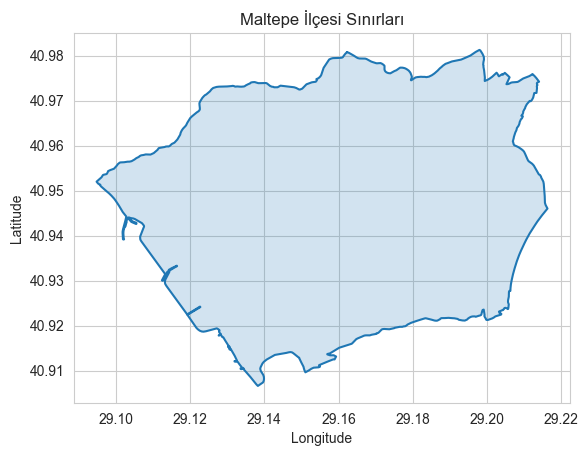

In [132]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y)
plt.fill(x, y, alpha=0.2)  # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [222]:
import json

# GeoJSON dosyasının yolu
dosya_yolu = "C:/Users/umutk/Downloads/mahalleler.geojson"

# GeoJSON dosyasını açın ve içeriği okuyun
with open(dosya_yolu, "r", encoding="utf-8") as dosya:
    geojson_verisi = json.load(dosya)

# Veriyi kontrol etmek için ekrana yazdır
type(geojson_verisi)

dict

In [166]:
geojson_verisi.keys()

dict_keys(['type', 'generator', 'copyright', 'timestamp', 'features'])

In [173]:
geojson_verisi['features'][1].keys()

dict_keys(['type', 'properties', 'geometry', 'id'])

In [188]:
geojson_verisi['features'][0]['properties'].keys()

dict_keys(['@id', 'admin_level', 'boundary', 'name', 'network', 'type'])

In [189]:
geojson_verisi['features'][0]['properties']['name']

'Kadıköy Mahallesi'

In [176]:
len(geojson_verisi['features'])

1983

In [223]:
maltepe_mahalle = []
mahalle_adlari = ['Altaycesme Mahallesi', 'Altintepe Mahallesi', 'Aydinevler Mahallesi', 
                  'Ba Mahallesi', 'Basibuyuk', 'Buyukbakkalkoy', 
                  'Cevizli', 'Cinar', 'Esenkent',
                  'Feyzullah', 'Findikli', 'Girne', 
                  'Gulensu', 'Gulsuyu', 'Idealtepe', 
                  'Kucukyali', 'Yali', 'Zumrutevler']

for i in np.arange(0,len(geojson_verisi['features'])):
    if geojson_verisi['features'][i]['properties']['name'] in mahalle_adlari:
        maltepe_mahalle.append(geojson_verisi['features'][i])
    else: continue

KeyError: 'name'

In [224]:
maltepe_mahalle = []
mahalle_adlari = ['Altayçeşme Mahallesi', 'Altıntepe Mahallesi', 'Aydınevler Mahallesi', 
                  'Bağlarbaşı Mahallesi', 'Başıbüyük Mahallesi', 'Büyükbakkalköy Mahallesi', 
                  'Cevizli Mahallesi', 'Çınar Mahallesi', 'Esenkent Mahallesi',
                  'Feyzullah Mahallesi', 'Fındıklı Mahallesi', 'Girne Mahallesi', 
                  'Gülensu Mahallesi', 'Gülsuyu Mahallesi', 'İdealtepe Mahallesi', 
                  'Küçükyalı Mahallesi', 'Yalı Mahallesi', 'Zümrütevler Mahallesi']

for feature in geojson_verisi['features']:
    properties = feature.get('properties', {})
    name = properties.get('name', None)
    if name in mahalle_adlari:
        maltepe_mahalle.append(feature)

In [217]:
maltepe_mahalle = []
mahalle_adlari = ['Altayçeşme Mahallesi', 'Altıntepe Mahallesi', 'Aydınevler Mahallesi', 
                  'Bağlarbaşı Mahallesi', 'Başıbüyük Mahallesi', 'Büyükbakkalköy Mahallesi', 
                  'Cevizli Mahallesi', 'Çınar Mahallesi', 'Esenkent Mahallesi',
                  'Feyzullah Mahallesi', 'Fındıklı Mahallesi', 'Girne Mahallesi', 
                  'Gülensu Mahallesi', 'Gülsuyu Mahallesi', 'İdealtepe Mahallesi', 
                  'Küçükyalı Mahallesi', 'Yalı Mahallesi', 'Zümrütevler Mahallesi']

for feature in geojson_verisi['features']:
    properties = feature.get('properties', {})
    name = properties.get('name', None)
    if name in mahalle_adlari:
        maltepe_mahalle.append(feature)

# Maltepe ilçesi sınırlarının min ve max koordinatları arasındaki mahalleleri filtreleme
maltepe_mahalle_filtreli = []
for mahalle in maltepe_mahalle:
    coords = mahalle['geometry']['coordinates'][0]
    for lon, lat in coords:
        if min_lon <= lon <= max_lon and min_lat <= lat <= max_lat:
            maltepe_mahalle_filtreli.append(mahalle)
            break  # Sadece bir kere eklemek için

In [219]:
maltepe_mahalle_filtreli

[]

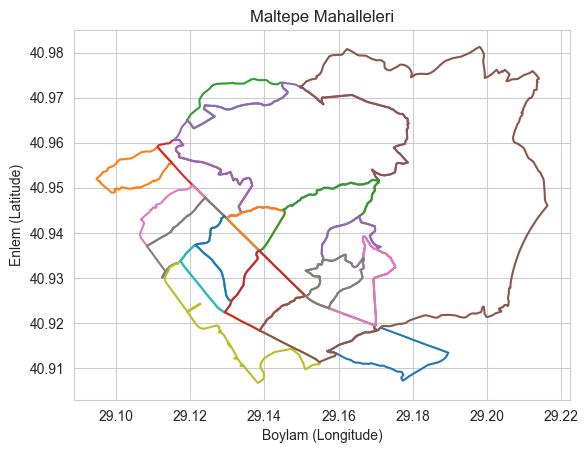

In [287]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'])

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)
plt.show()

# OSM POI verilerini cekip ekleyelim, tekrardan olusturalim

In [52]:
import osmium
import csv

class POIHandler(osmium.SimpleHandler):
    def __init__(self, output_file):
        super(POIHandler, self).__init__()
        self.output_file = output_file

    def node(self, n):
        if 'amenity' in n.tags and n.tags['amenity'] in ['restaurant', 'cafe', 'bar', 'park', 'school']:
            # Maltepe ilçesindeki POI'leri filtrelemek için Maltepe'nin koordinatlarına göre kontrol yapabilirsiniz
            if n.location.lon >= min_lon and n.location.lon <= max_lon and n.location.lat >= min_lat and n.location.lat <= max_lat:
                # POI'nin konumu ve adını CSV dosyasına yaz
                with open(self.output_file, 'a', newline='', encoding='utf-8') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow([n.tags.get('name', 'Unknown'), n.location.lat, n.location.lon])

file_path = '/home/umutky/PycharmProjects/engineering_project/data/turkey-latest.osm.pbf'
output_file = 'maltepe_poi.csv'

# CSV dosyasını temizle
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['POI Name', 'Latitude', 'Longitude'])

# POI işleyicisi oluştur
handler = POIHandler(output_file)

# OSM verilerini işle
handler.apply_file(file_path)

In [53]:
osm_poi = pd.read_csv('maltepe_poi.csv')
osm_poi.head()

,POI Name,Latitude,Longitude
0,Özel Derece Okulları,40.933552,29.119136
1,zeythin,40.978181,29.107032
2,Fırtına Restoran,40.949021,29.106206
3,Mado,40.924028,29.126309
4,Hasan Usta Bostancı İskele,40.953246,29.095125


In [54]:
atm_coords = maltepe_banka_atm[['longitude', 'latitude']].values
akarayakit_coords = maltepe_akaryakit[['longitude', 'latitude']].values
tum_rakipler_coords = tum_rakipler[['longitude', 'latitude']].values
duraklar_coords = maltepe_duraklar[['longitude', 'latitude']].values
otopark_coords = maltepe_otopark[['longitude', 'latitude']].values
kendi_magazalarimiz = migros_df[['Longitude', 'Latitude']].values
poi_coords = osm_poi[['Longitude', 'Latitude']].values


NameError: name 'maltepe_banka_atm' is not defined

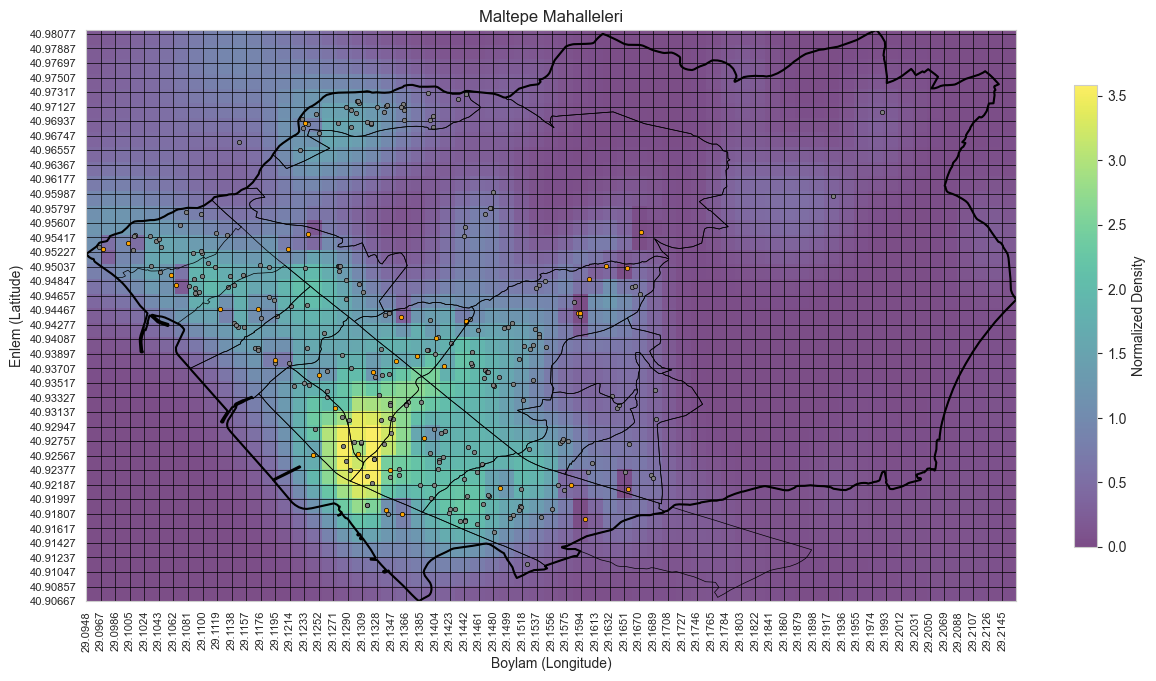

In [286]:
from sklearn.preprocessing import MinMaxScaler

# Kategoriler için KDE modellerinin oluşturulması
kde_atm = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(atm_coords)
kde_akarayakit = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(akarayakit_coords)
kde_rakip_magaza = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(tum_rakipler_coords)
kde_duraklar = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(duraklar_coords)
kde_otopark = KernelDensity(bandwidth=0.003, kernel='gaussian', metric='haversine').fit(otopark_coords)
kde_kendi_magaza = KernelDensity(bandwidth=0.001, kernel='gaussian', metric='haversine').fit(kendi_magazalarimiz)
kde_poi = KernelDensity(bandwidth=0.005, kernel='gaussian', metric='haversine').fit(poi_coords)

# İstediğiniz etiket aralıklarını belirleyin
lon_tick_interval = 0.0019
lat_tick_interval = 0.0019

# İzgara adım sayılarını hesaplayın
lon_num_steps = int((max_lon - min_lon) / lon_tick_interval)
lat_num_steps = int((max_lat - min_lat) / lat_tick_interval)

# Izgara oluşturma
x_grid, y_grid = np.mgrid[min_lon:max_lon:lon_num_steps*1j, min_lat:max_lat:lat_num_steps*1j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Her bir kategorinin yoğunluk değerlerinin hesaplanması
density_atm = np.exp(kde_atm.score_samples(positions.T))
density_akarayakit = np.exp(kde_akarayakit.score_samples(positions.T))
density_rakip_magaza = np.exp(kde_rakip_magaza.score_samples(positions.T))
density_duraklar = np.exp(kde_duraklar.score_samples(positions.T))
density_otopark = np.exp(kde_otopark.score_samples(positions.T))
density_kendi_magaza = np.exp(kde_kendi_magaza.score_samples(positions.T))
density_poi = np.exp(kde_poi.score_samples(positions.T))

# MinMaxScaler uygulanması
scaler = MinMaxScaler()
scaled_density_atm = scaler.fit_transform(density_atm.reshape(-1, 1)).reshape(density_atm.shape)
scaled_density_akarayakit = scaler.fit_transform(density_akarayakit.reshape(-1, 1)).reshape(density_akarayakit.shape)
scaled_density_rakip_magaza = scaler.fit_transform(density_rakip_magaza.reshape(-1, 1)).reshape(density_rakip_magaza.shape)
scaled_density_duraklar = scaler.fit_transform(density_duraklar.reshape(-1, 1)).reshape(density_duraklar.shape)
scaled_density_otopark = scaler.fit_transform(density_otopark.reshape(-1, 1)).reshape(density_otopark.shape)
scaled_density_kendi_magaza = scaler.fit_transform(density_kendi_magaza.reshape(-1, 1)).reshape(density_kendi_magaza.shape)
scaled_density_poi = scaler.fit_transform(density_poi.reshape(-1, 1)).reshape(density_poi.shape)

# Toplam yoğunluk hesaplama
total_density = scaled_density_atm + scaled_density_akarayakit + scaled_density_rakip_magaza + scaled_density_duraklar + scaled_density_otopark - 2*scaled_density_kendi_magaza + scaled_density_poi

total_density = total_density.reshape(x_grid.shape)
total_density[total_density < 0] = 0

# Figürün oluşturulması ve görselleştirme
plt.figure(figsize=(15, 12))
plt.imshow(np.rot90(total_density), cmap=plt.cm.viridis, extent=[min_lon, max_lon, min_lat, max_lat], alpha=0.7)
plt.colorbar(label='Normalized Density', shrink=0.5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(min_lon, max_lon, 0.0019), rotation=90, fontsize=8)
plt.yticks(np.arange(min_lat, max_lat, 0.0019), fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Veri setinizdeki koordinatlar
coordinates = maltepe_ilce_polygon['coordinates'][0]

# Polygon oluşturma
polygon = Polygon(coordinates)

# Polygon çizimi
x, y = polygon.exterior.xy
plt.plot(x, y, color='black') # Polygonu doldurma
plt.title('Maltepe İlçesi Sınırları')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Her bir mahalle için geometriyi çizme
for mahalle_verisi in maltepe_mahalle_filtreli:
    coordinates = mahalle_verisi['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    x, y = polygon.exterior.xy
    plt.plot(x, y, label=mahalle_verisi['properties']['name'], color='black', linewidth= .5)

# Grafiği gösterme
plt.title('Maltepe Mahalleleri')
plt.xlabel('Boylam (Longitude)')
plt.ylabel('Enlem (Latitude)')
plt.grid(True)

# Koordintlarin scatter plot ile eklenmesi
#plt.scatter(atm_coords[:, 0], atm_coords[:, 1], color='blue', label='ATM', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(akarayakit_coords[:, 0], akarayakit_coords[:, 1], color='red', label='Banka', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(tum_rakipler_coords[:, 0], tum_rakipler_coords[:, 1], color='grey', label='rakip_magaza', marker='o', edgecolors='black', linewidth=.5, s=10)
#plt.scatter(duraklar_coords[:, 0], duraklar_coords[:, 1], color='yellow', label='duraklar', marker='o', edgecolors='black', linewidth=.5, s=5)
#plt.scatter(otopark_coords[:, 0], otopark_coords[:, 1], color='green', label='otopark', marker='o', edgecolors='black', linewidth=.5, s=5)
plt.scatter(kendi_magazalarimiz[:, 0], kendi_magazalarimiz[:, 1], color='orange', label='migros', marker='o', edgecolors='black', linewidth=.5, s=10)
# plt.scatter(poi_coords[:, 0], poi_coords[:, 1], color='red', label='poi', marker='o', edgecolors='black', linewidth=.5, s=10)

plt.show()